# Sample Mass-Difference Networks (MDiNs) Notebooks

- Sample_MDiNs_Yeast.ipynb
- Sample_MDiNs_Grapevine.ipynb
- Formula_Networks_Yeast.ipynb

# Sample Mass-Difference Networks (MDiNs) of the Grapevine Datasets

This notebook will cover the explorative studies into making networks from a list of masses - Mass-Difference Networks. Each m/z will represent a node. Nodes will be connected if the difference in their masses can be associated to a simple chemical reaction (enzymatic or non-enzymatic) that led to a change in the elemental composition of its metabolite.

The set of mass differences are called a set of MDBs - Mass-Difference-based Building block.

### Organization of the networks:

- Construction of the files with lists of masses for MDiN construction (MetaNetter plugin of Cytoscape)
- Construction of the transformations (MDBs) list for MDiN construction (done in Sample_MDiNs_Yeast.ipynb file)
- Reading Networks constructed and extraction of some of their main characteristics (full grapevine networks with either our transformation list - TF - or MetaNetter's - MN)
- Test of the analysis methods used later on with the sample MDiNs
- Building the sample MDiNs by inducing subgraphs of the complete networks (both TF and MN)
- Building secondary datasets by applying the different network analysis (explanations of some of them) methods to the sample MDiNs - each secondary dataset is identified by the network analysis methods that gave origin to it.
- Unsupervised Statistical Analysis (HCA and K-means clustering) of the secondary datasets (for both TF and MN)
- Supervised Statistical Analysis (Random Forest and PLS-DA), optimization, application and results (only TF)
- Permutation Tests (Supervised Analysis) - only TF
- Test if induced subgraphs of complete networks to build a sample MDiN is identical to building it from scratch.


### Needed imports

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import metabolinks as mtl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats
import multianalysis as ma
import metabolinks.transformations as transf
import netlsd as nl
import itertools

C:\Users\francisco\Anaconda3\lib\site-packages\xarray\core\merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


## 2 types of network construction using the MetaNetter 2.0 plugin of Cytoscape, the first one was the one used in the Masters dissertation:

### 1 - NetTF - Using our Transformation List (TF) created here with the transformations mentioned and described later.


### 2 - NetMN - Using the transformation list default to the plugin MetaNetter /MN), only considering most of the small chemical transformations (until a max of 80 m/z).

- Took out Arginine, Arg to Ornitine (aminoacid related) and pyrophosphate (PP) from the MetaNetter list.
- Left 30 different transformations - double from our transformation list, more edges expected in the resulting networks.
- Most of our 15 transformation list is in this list with some exceptions (S, CHOH and NCH), some differences (different de-amination). One different MDB is noteworthy - carbamoylatransferase - where only one can be correct (CONH in our list versus CONH2 in theirs). I believe the ours is more correct as can be seen by the reaction example at: https://www.brenda-enzymes.org/enzyme.php?ecno=2.1.3.11

MetaNetter papers:

- MetaNetter - https://academic.oup.com/bioinformatics/article/24/1/143/205461 
- MetaNetter 2.0 - https://pubmed.ncbi.nlm.nih.gov/29030098/

## 2 analysis of 2 grapevine dataset networks (negative and positive) - total 4.


#### The two transformations lists were analysed. After observation that results from both were similar despite the smaller networks from NetTF (since less transformations were considered), NetTF results were chosen to show in the dissertation since its transformation list is closer to what we wanted to represent with these sample MDiNs in the dissertation.

## Building the MDiNs for the Grapevine datasets in Cytoscape

To build the network in Cytoscape we'll need:

1) A list of neutral masses (with masses as float in node attributes).

2) A list of allowed transformations with specific mass differences (that will be in one case ours (TF), and in the other case from the default MetaNetter list (MN) as explained).

## Create list of neutral masses from the m/z peaks of the Grapevine datasets to use in Cytoscape to build the different networks

#### Reading Grapevine datasets stored in alignments_new.h5

Grapevine datasets peak filtering: feature present in at least 2 of the 33 samples in the dataset - 'all_1ppm_min2'.

In [2]:
# Reading Grapevine Datasets
aligned_all_pos = pd.HDFStore('alignments_new.h5').get('all_1ppm_min2_pos')
aligned_all_neg = pd.HDFStore('alignments_new.h5').get('all_1ppm_min2_neg')

In [3]:
aligned_all_pos

label      CAN                      CS               LAB                      \
            14  15        16        29  30        31   8         9        10   
96.999045  NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
97.031130  NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
97.071640  NaN NaN       NaN       NaN NaN       NaN NaN  108081.0       NaN   
97.100765  NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
97.177455  NaN NaN  104165.0  146957.0 NaN  166304.0 NaN       NaN  153067.0   
...         ..  ..       ...       ...  ..       ...  ..       ...       ...   
853.851470 NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
863.742605 NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
864.749430 NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
885.372610 NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
907.353940 NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   

label             PN  ... ROT        RU                           SYL  \
                  23  ...  22        35        36        37        11   
96.999045        NaN  ... NaN       NaN       NaN       NaN  106869.0   
97.031130    98169.0  ... NaN       NaN       NaN       NaN       NaN   
97.071640        NaN  ... NaN       NaN       NaN       NaN       NaN   
97.100765   179818.0  ... NaN       NaN       NaN       NaN       NaN   
97.177455   275602.0  ... NaN  430984.0  382831.0  712734.0  171313.0   
...              ...  ...  ..       ...       ...       ...       ...   
853.851470  472207.0  ... NaN       NaN       NaN       NaN       NaN   
863.742605       NaN  ... NaN       NaN       NaN  161976.0       NaN   
864.749430       NaN  ... NaN       NaN       NaN       NaN       NaN   
885.372610  973025.0  ... NaN       NaN       NaN       NaN       NaN   
907.353940       NaN  ... NaN       NaN       NaN       NaN       NaN   

label                          TRI                      
                  12  13        32        33        34  
96.999045        NaN NaN       NaN  110856.0       NaN  
97.031130        NaN NaN       NaN       NaN       NaN  
97.071640   110127.0 NaN       NaN       NaN       NaN  
97.100765        NaN NaN       NaN       NaN       NaN  
97.177455   113533.0 NaN       NaN  198609.0  496041.0  
...              ...  ..       ...       ...       ...  
853.851470       NaN NaN       NaN       NaN       NaN  
863.742605       NaN NaN  268862.0       NaN  269364.0  
864.749430       NaN NaN  130892.0       NaN       NaN  
885.372610       NaN NaN       NaN       NaN       NaN  
907.353940       NaN NaN       NaN       NaN       NaN  

[7026 rows x 33 columns]

#### Transform the index of the datasets to represent "neutral" masses

A simple transformation by adding or removing a proton (Hydrogen atom mass - electron mass) to the Negative or Positive Grapevine dataset.

In [4]:
# Atomic masses - https://ciaaw.org/atomic-masses.htm
#Isotopic abundances-https://ciaaw.org/isotopic-abundances.htm/https://www.degruyter.com/view/journals/pac/88/3/article-p293.xml
# Isotopic abundances from Pure Appl. Chem. 2016; 88(3): 293–306,
# Isotopic compositions of the elements 2013 (IUPAC Technical Report), doi: 10.1515/pac-2015-0503

chemdict = {'H':(1.0078250322, 0.999844),
            'C':(12.000000000, 0.988922),
            'N':(14.003074004, 0.996337),
            'O':(15.994914619, 0.9976206),
            'Na':(22.98976928, 1.0),
            'P':(30.973761998, 1.0),
            'S':(31.972071174, 0.9504074),
            'Cl':(34.9688527, 0.757647),
            'F':(18.998403163, 1.0),
            'C13':(13.003354835, 0.011078) #Carbon 13 isotope
           }  

In [5]:
# electron mass from NIST http://physics.nist.gov/cgi-bin/cuu/Value?meu|search_for=electron+mass
electron_mass = 0.000548579909065

# New indexes
new_index_pos = aligned_all_pos.index - chemdict['H'][0] + electron_mass
new_index_neg = aligned_all_neg.index + chemdict['H'][0] - electron_mass

In [6]:
# Change the indexes
aligned_all_pos.index = new_index_pos
aligned_all_neg.index = new_index_neg

In [7]:
aligned_all_pos

label      CAN                      CS               LAB                      \
            14  15        16        29  30        31   8         9        10   
95.991769  NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
96.023854  NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
96.064364  NaN NaN       NaN       NaN NaN       NaN NaN  108081.0       NaN   
96.093489  NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
96.170179  NaN NaN  104165.0  146957.0 NaN  166304.0 NaN       NaN  153067.0   
...         ..  ..       ...       ...  ..       ...  ..       ...       ...   
852.844194 NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
862.735329 NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
863.742154 NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
884.365334 NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
906.346664 NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   

label             PN  ... ROT        RU                           SYL  \
                  23  ...  22        35        36        37        11   
95.991769        NaN  ... NaN       NaN       NaN       NaN  106869.0   
96.023854    98169.0  ... NaN       NaN       NaN       NaN       NaN   
96.064364        NaN  ... NaN       NaN       NaN       NaN       NaN   
96.093489   179818.0  ... NaN       NaN       NaN       NaN       NaN   
96.170179   275602.0  ... NaN  430984.0  382831.0  712734.0  171313.0   
...              ...  ...  ..       ...       ...       ...       ...   
852.844194  472207.0  ... NaN       NaN       NaN       NaN       NaN   
862.735329       NaN  ... NaN       NaN       NaN  161976.0       NaN   
863.742154       NaN  ... NaN       NaN       NaN       NaN       NaN   
884.365334  973025.0  ... NaN       NaN       NaN       NaN       NaN   
906.346664       NaN  ... NaN       NaN       NaN       NaN       NaN   

label                          TRI                      
                  12  13        32        33        34  
95.991769        NaN NaN       NaN  110856.0       NaN  
96.023854        NaN NaN       NaN       NaN       NaN  
96.064364   110127.0 NaN       NaN       NaN       NaN  
96.093489        NaN NaN       NaN       NaN       NaN  
96.170179   113533.0 NaN       NaN  198609.0  496041.0  
...              ...  ..       ...       ...       ...  
852.844194       NaN NaN       NaN       NaN       NaN  
862.735329       NaN NaN  268862.0       NaN  269364.0  
863.742154       NaN NaN  130892.0       NaN       NaN  
884.365334       NaN NaN       NaN       NaN       NaN  
906.346664       NaN NaN       NaN       NaN       NaN  

[7026 rows x 33 columns]

### Writing a .csv file for each of the datasets with the list of masses that will be used to build the MDiNs (in Cytoscape's MetaNetter)

The file needs to be correctly read by Cytoscape's MetaNetter (and Cytoscape) where the network will be built.

For this, files with two columns both with the same list of masses (one index, one in the column) will be made. One will correspond to the network nodes names as a 'string'. The other will be an attribute of the corresponding node as a 'float' and will be used in the building process.

In [8]:
pd.DataFrame(aligned_all_pos.index, index=aligned_all_pos.index).to_csv('MassList_PGD.csv')
pd.DataFrame(aligned_all_neg.index, index=aligned_all_neg.index).to_csv('MassList_NGD.csv')

### Making the transformation file - Made in Sample_MDiNs_Yeast.ipynb

In [9]:
#Chemical Transformation list
MDBs = ['H2','CH2','CO2','O','CHOH','NCH','O(-NH)','S','CONH','PO3H','NH3(-O)','SO3','CO', 'C2H2O', 'H2O']

## Building the full network for the full Grapevine datasets in Cytoscape

To build the network in Cytoscape we'll need:

1) A list of masses (with masses as float in node attributes).

2) A list of allowed transformations with specific mass differences (that will be in one case ours and in the other case from the default MetaNetter list as explained).

The network built in Cytoscape had a 1 ppm error allowed for edge establishment. Discussions on the format the network built is done later. Also, only one full network (in each case is done) and then subgraphs of it will be used for every sample instead of building one for each sample (also explained later).

## Build the Networks in Cytoscape using MetaNetter 2.0

The transformation files and the Grapevine datasets files were used in Cytoscape to build the MDiNs.

Parameters: 1 ppm error allowed for edge establishment.

Discussions on the format of the network built is done later. Also, only one full network (in each case is done) and then subgraphs of it will be used for every sample MDiN instead of building one for each sample (also explained later).

#### 'Net_NGD_TF.graphml' - NegTF - Negative Grapevine Dataset Network made with the transformation list built in this notebook.
#### 'Net_NGD_MN.graphml' - NegMN - Negative Grapevine Dataset Network made with the MetaNetter transformation list as explained in the beginning of the notebook.

#### 'Net_PGD_TF.graphml' - PosTF - Positive Grapevine Dataset Network made with the transformation list built in this notebook.
#### 'Net_PGD_MN.graphml' - PosMN - Positive Grapevine Dataset Network made with the MetaNetter transformation list as explained in the beginning of the notebook.

## Reading the network obtained from Cytoscape after MDiN built from MetaNetter

The networks were exported in graphml format that networkX module can read.

- Nodes have a standard 'number' ID instead of the mass which is fortunately stored as the attribute 'mass'. Other attributes stored are irrelevant. 
- Edges among the different attributes have a very useful attribute called 'Transformation' which stores which MDB of the list was used to establish the edge - will be used for MDB Influence analysis.
- Finally, the graph is directed despite only having one connection between any two nodes. Since reactions are bidireccional, they will be transformed to undirected graphs. Below it is shown that the number of edges remains the same between the directed and undirected graph.

Changes that will be made to the network:

- Nodes will be identified by their masses.
- Formulas (when given) will be stored as node attributes.
- Intensities of the node in each sample will be given later to store for each specific subgraph.

### NegTF and PosTF - Networks made with our list of transformations

In [10]:
# Reading the networks made
NegTF_dir = nx.read_graphml('Net_NGD_TF.graphml')
NegTF = NegTF_dir.to_undirected()

PosTF_dir = nx.read_graphml('Net_PGD_TF.graphml')
PosTF = PosTF_dir.to_undirected()

In [11]:
# Info for part of Table 3.4
print('Nº of nodes and edges in directed Negative Grapevine graph: \t', len(NegTF_dir.nodes()), ',\t',len(NegTF_dir.edges()))
print('Nº of nodes and edges in undirected Negative Grapevine graph: \t',len(NegTF.nodes()), ',\t',len(NegTF.edges()))

print('Nº of nodes and edges in directed Positive Grapevine graph: \t', len(PosTF_dir.nodes()), ',\t',len(PosTF_dir.edges()))
print('Nº of nodes and edges in undirected Positive Grapevine graph: \t',len(PosTF.nodes()), ',\t',len(PosTF.edges()))

Nº of nodes and edges in directed Negative Grapevine graph: 	 3629 ,	 1005
Nº of nodes and edges in undirected Negative Grapevine graph: 	 3629 ,	 1005
Nº of nodes and edges in directed Positive Grapevine graph: 	 7026 ,	 6597
Nº of nodes and edges in undirected Positive Grapevine graph: 	 7026 ,	 6597


In [12]:
# Making dicts for the new names
new_nodes = dict.fromkeys(NegTF.nodes(),0)

for i,j in nx.get_node_attributes(NegTF,'mass').items(): #i is old name, j is mass/new name
    #print(i,j)
    new_nodes[i] = j

# Relabeling nodes
NegTF = nx.relabel_nodes(NegTF, mapping=new_nodes)

In [13]:
# Making dicts for the new names
new_nodes = dict.fromkeys(PosTF.nodes(),0)

for i,j in nx.get_node_attributes(PosTF,'mass').items(): #i is old name, j is mass/new name
    #print(i,j)
    new_nodes[i] = j

# Relabeling nodes
PosTF = nx.relabel_nodes(PosTF, mapping=new_nodes)

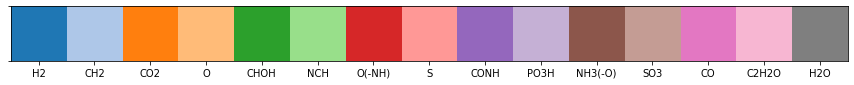

In [14]:
colours = sns.color_palette('tab20', 15)

unique_MDB = ['H2','CH2','CO2','O','CHOH','NCH','O(-NH)','S','CONH','PO3H','NH3(-O)','SO3','CO', 'C2H2O', 'H2O']
MDB_colors = {lbl: c for lbl, c in zip(unique_MDB, colours)}

sns.palplot(MDB_colors.values())
new_ticks = plt.xticks(range(len(unique_MDB)), unique_MDB)

#### Plotting the Negative Grapevine Dataset MDiN and Small Characterization of the network - Info for part of Table 3.4

C:\Users\francisco\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\francisco\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
C:\Users\francisco\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


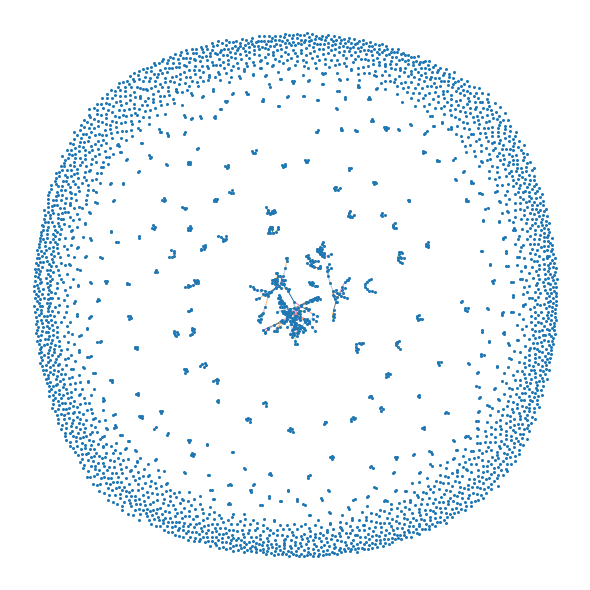

In [15]:
# Drawing the full network for the dataset - Negative Grapevine Dataset MDiN
edge_colors =  [MDB_colors[lbl] for lbl in nx.get_edge_attributes(NegTF,'Transformation').values()]
plt.figure(figsize=(8,8))
nx.draw(NegTF, node_size=4, width = 1, edge_color=edge_colors)
plt.show()

In [16]:
# Spread of components
[len(c) for c in sorted(nx.connected_components(NegTF), key=len, reverse=True)][:20]

[183, 21, 21, 18, 15, 13, 12, 12, 12, 11, 9, 9, 9, 7, 7, 7, 6, 6, 6, 6]

In [17]:
#Diameter and Radius of the Network
Main_component = NegTF.subgraph(list(sorted(nx.connected_components(NegTF), key=len, reverse=True)[0]))
print('Diameter of the network:', nx.diameter(Main_component))
print('Radius of the network:', nx.radius(Main_component))

Diameter of the network: 27
Radius of the network: 14


In [18]:
isolated = 0
for i in NegTF.degree():
    if i[1] == 0:
        isolated = isolated + 1

print('Nº of nodes without connections:', isolated)

Nº of nodes without connections: 2452


#### Plotting the Positive Grapevine Dataset MDiN and Small Characterization of the network - Info for part of Table 3.4

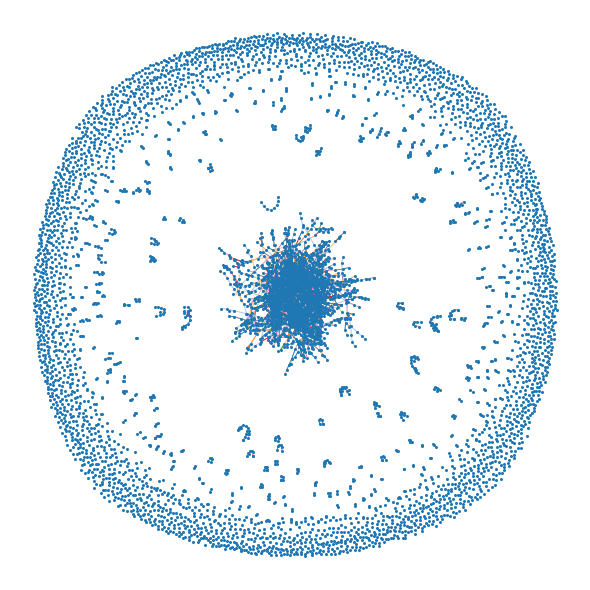

In [19]:
# Drawing the full network for the dataset - Positive Grapevine Dataset MDiN
edge_colors =  [MDB_colors[lbl] for lbl in nx.get_edge_attributes(PosTF,'Transformation').values()]
plt.figure(figsize=(8,8))
nx.draw(PosTF, node_size=4, width = 1, edge_color=edge_colors)
plt.show()

In [20]:
# Spread of components
[len(c) for c in sorted(nx.connected_components(PosTF), key=len, reverse=True)][:20]

[2482, 49, 40, 26, 19, 18, 17, 17, 16, 16, 13, 11, 11, 11, 10, 9, 9, 9, 9, 9]

In [21]:
# Diameter and Radius of the Network
Main_component = PosTF.subgraph(list(sorted(nx.connected_components(PosTF), key=len, reverse=True)[0]))
print('Diameter of the network:', nx.diameter(Main_component))
print('Radius of the network:', nx.radius(Main_component))

Diameter of the network: 49
Radius of the network: 25


In [22]:
isolated = 0
for i in PosTF.degree():
    if i[1] == 0:
        isolated = isolated + 1

print('Nº of nodes without connections:', isolated)

Nº of nodes without connections: 3110


#### Negative Grapevine Dataset Network Analysis with out transformation list (same analysis that will be done for each individual sample network)

5 methods were applied (explanations after when applied to sample MDiNs)

- 3 centrality measures (Degree, Betweenness centrality, Closeness centrality)
- MDB Influence
- GCD-11

A 6 method called NetLSD that was applied in Sample_MDiNs_Yeast.ipynb and wasn't shown in the dissertation won't be applied here.

3 measures of centrality were used to analyze the networks: degree, betweenness centrality and centrality closeness.

In [23]:
# Degree
NegTF_degree = dict(NegTF.degree())
NegTF_degree_all = sorted(NegTF_degree.items(), key=lambda kv: kv[1], reverse = True)
NegTF_degree_all[:10]

[(344.1113464522909, 10),
 (344.1109764522909, 8),
 (282.2565264522909, 8),
 (374.1584564522909, 7),
 (342.0957614522909, 7),
 (299.2546264522909, 7),
 (298.2512464522909, 7),
 (270.2202564522909, 7),
 (597.279296452291, 6),
 (356.1113364522909, 6)]

In [24]:
# Betweenness Centrality
NegTF_betw = nx.betweenness_centrality(NegTF)
NegTF_betw_all = sorted(NegTF_betw.items(), key=lambda kv: kv[1], reverse = True)
NegTF_betw_all[:10]

[(342.1323964522909, 0.0012777925949737376),
 (312.17625645229094, 0.0012522460329836649),
 (344.1482664522909, 0.0012509541175472817),
 (326.1917864522909, 0.001244646530416705),
 (340.2076214522909, 0.0012406187940562162),
 (370.1271264522909, 0.001219370514287544),
 (308.2358864522909, 0.0012078649379926186),
 (280.2408914522909, 0.0011938396447768),
 (372.1427964522909, 0.0007650925867663072),
 (282.2565264522909, 0.0007586580025760454)]

In [25]:
# Closeness Centrality
NegTF_closeness = nx.closeness_centrality(NegTF)
NegTF_closeness_all = sorted(NegTF_closeness.items(), key=lambda kv: kv[1], reverse = True)
NegTF_closeness_all[:10]

[(342.1323964522909, 0.007006983291039845),
 (370.1271264522909, 0.006953617081664066),
 (344.1482664522909, 0.006921985768176587),
 (312.17625645229094, 0.006813506886735012),
 (326.1917864522909, 0.006688717383314958),
 (356.1113364522909, 0.006592129406660591),
 (340.2076214522909, 0.006549569030290471),
 (300.12162145229087, 0.0065401856935708574),
 (326.1377564522909, 0.0065214994487320845),
 (356.11173145229094, 0.006516844559760826)]

#### MDB Influence calculation (H2, CH2, O, CO and H2O with a high group influences) - Info for part of Suppl. Table 6.3

In [26]:
# MDB Influence in building the network
NegTF_MDBs = dict.fromkeys(unique_MDB, 0) # MDBs from the transformation list
for i in NegTF.edges():
    NegTF_MDBs[NegTF.edges()[i]['Transformation']] = NegTF_MDBs[NegTF.edges()[i]['Transformation']] + 1

NegTF_MDBs

{'H2': 138,
 'CH2': 173,
 'CO2': 61,
 'O': 135,
 'CHOH': 36,
 'NCH': 34,
 'O(-NH)': 50,
 'S': 8,
 'CONH': 24,
 'PO3H': 9,
 'NH3(-O)': 120,
 'SO3': 9,
 'CO': 111,
 'C2H2O': 39,
 'H2O': 58}

GCD-11 Analysis - Graphlet Correlation Distance of 11 different orbits (maximum of 4-node graphlets)

In [27]:
def calculating_orbits(GG):
    """Calculates the number of times each node of the network is in each possible (non-redundant) orbit in graphlets (maximum
    4 nodes).
    
    Function is not very efficient, all nodes are passed, every graphlet is 'made' for each node present in it so it is made
    multiple times.
    
       GG: networkx graph;
    
       returns: dict; dictionary (keys are the nodes) of dictionaries (keys are the orbits and values are the number of times)
    """
    
    node_orbits = {} # To store results

    for i in GG.nodes():

        node_orbits[i] = {} # To store results
        orbits = node_orbits[i]

        ## size of comp
        # comp = len(nx.node_connected_component(GG, 'c'))

        # 2 node graphlets - orbit 0
        orbits['0'] = GG.degree(i)

        # 3 node graphlets - orbit 1,2 (and 3 redundant)
        node_neigh = list(GG.neighbors(i))

        # orbit 1 and 4 and 6 and 8 and 9
        n_orb = 0
        n_orb4 = 0
        n_orb6 = 0
        n_orb8 = 0
        n_orb9 = 0

        # orbit 1
        for j in node_neigh:
            neigh_neigh = list(GG.neighbors(j)) # Neighbours of the neighbour j of i
            neigh_neigh.remove(i) # Remove i since i is a neighbour of j
            for common in nx.common_neighbors(GG, i, j):
                neigh_neigh.remove(common) # Remove common neighbours of i and j
            n_orb = n_orb + len(neigh_neigh)


            # orbit 4 and 8
            for n3 in neigh_neigh:
                neigh_neigh_neigh = list(GG.neighbors(n3)) # Neighbours of the neighbour n3 of the neighbour j of i
                #neigh_neigh_neigh.remove(j)
                #if i in neigh_neigh_neigh:
                    #neigh_neigh_neigh.remove(i)     
                for common in nx.common_neighbors(GG, j, n3):
                    if common in neigh_neigh_neigh:
                        neigh_neigh_neigh.remove(common)

                for common in nx.common_neighbors(GG, i, n3):
                    if common in neigh_neigh_neigh:
                        neigh_neigh_neigh.remove(common)
                        # orbit 8
                        if common != j:
                            #print(i,j,n3,common)
                            n_orb8 = n_orb8 + 1/2 # always goes in 2 directions so it will always pass like this

                n_orb4 = n_orb4 + len(neigh_neigh_neigh)
                # print(neigh_neigh_neigh)

            # orbit 6 and 9
            for u,v in itertools.combinations(neigh_neigh, 2):
                if not GG.has_edge(u,v):
                    n_orb6 = n_orb6 + 1
                else:
                    n_orb9 = n_orb9 + 1         

        orbits['1'] = n_orb

        # orbit 2 and 5
        n_orb = 0
        n_orb5 = 0
        for u,v in itertools.combinations(node_neigh, 2):
            if not GG.has_edge(u,v):
                n_orb = n_orb + 1

                # orbit 5
                neigh_u = list(GG.neighbors(u))
                neigh_u.remove(i)
                for common in nx.common_neighbors(GG, i, u):
                    neigh_u.remove(common)

                neigh_v = list(GG.neighbors(v))
                neigh_v.remove(i)
                for common in nx.common_neighbors(GG, i, v):
                    neigh_v.remove(common)

                for common in nx.common_neighbors(GG, v, u):
                    if common in neigh_u:
                        neigh_u.remove(common)
                    if common in neigh_v:
                        neigh_v.remove(common) 

                n_orb5 = n_orb5 + len(neigh_u)
                n_orb5 = n_orb5 + len(neigh_v)

        orbits['2'] = n_orb

        # 4 node graphlets - orbit 4,5,6,7,8,9,10,11 (and 12,13,14 redundant)

        # orbit 4
        orbits['4'] = n_orb4

        # orbit 5
        orbits['5'] = n_orb5

        # orbit 6
        orbits['6'] = n_orb6

        # orbit 7 and 11
        n_orb = 0
        n_orb11 = 0
        for u,v,j in itertools.combinations(node_neigh, 3):
            n_edge = [GG.has_edge(a,b) for a,b in itertools.combinations((u,v,j), 2)]
            #print(sum(n_edge))
            if sum(n_edge) == 0:
                n_orb = n_orb + 1
            elif sum(n_edge) == 1:
                n_orb11 = n_orb11 + 1

        orbits['7'] = n_orb

        # orbit 8
        orbits['8'] = int(n_orb8)

        # orbit 9
        orbits['9'] = n_orb9

        # orbit10
        n_orb = 0
        for j in node_neigh:
            neigh_neigh = list(GG.neighbors(j))
            neigh_neigh.remove(i)
            for u,v in itertools.combinations(neigh_neigh, 2):
                if sum((GG.has_edge(i,u), GG.has_edge(i,v))) == 1:
                    if not GG.has_edge(u,v):
                        n_orb = n_orb + 1

        orbits['10'] = n_orb

        # orbit 11
        orbits['11'] = n_orb11
    
    return node_orbits

In [28]:
# Counting the number of the number of times each node has each of the 11 orbits, make it a DataFrame
NegTF_GCD = calculating_orbits(NegTF)
NegTF_GCD_df = pd.DataFrame.from_dict(NegTF_GCD).T

# Graphlet Correlation Matrix (Spearman correlation between the different columns - orbits)
NegTF_CorrMat = stats.spearmanr(NegTF_GCD_df,axis=0)[0]

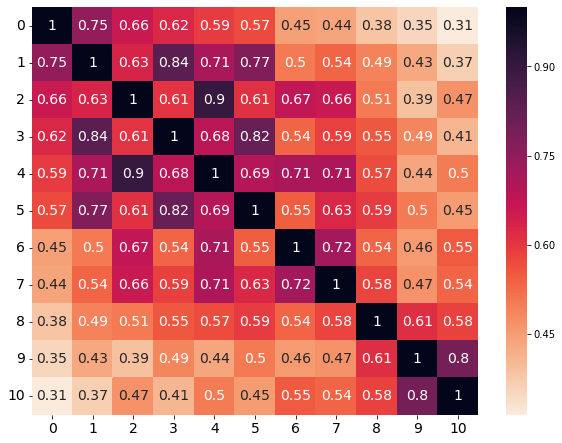

In [29]:
# Representing the Graphlet Correlation Matrix
f, ax = plt.subplots(figsize=(10, 7.5))
hm = sns.heatmap(NegTF_CorrMat, annot=True, ax=ax, cmap = sns.cm.rocket_r, annot_kws={"size": 14})
bottom, top = ax.get_ylim()
pos, textvals = plt.yticks()
plt.yticks(np.arange(11)+0.5,(textvals), rotation=0, fontsize="10", va="center")
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(labelsize= 14)
plt.show()

#### Positive Grapevine Dataset Network Analysis with our transformation list (SAME analysis that will be done for each individual sample network)

3 measures of centrality were used to analyze the networks: degree, betweenness centrality and centrality closeness.

In [30]:
# Degree
PosTF_degree = dict(PosTF.degree())
PosTF_degree_all = sorted(PosTF_degree.items(), key=lambda kv: kv[1], reverse = True)
PosTF_degree_all[:10]

[(266.1484735477091, 18),
 (308.1955135477091, 17),
 (278.11232854770907, 17),
 (269.2710835477091, 17),
 (339.34932354770905, 16),
 (306.2162135477091, 16),
 (297.2661135477091, 16),
 (280.1279935477091, 16),
 (264.1328035477091, 16),
 (244.06178354770907, 16)]

In [31]:
# Betweenness Centrality
PosTF_betw = nx.betweenness_centrality(PosTF)
PosTF_betw_all = sorted(PosTF_betw.items(), key=lambda kv: kv[1], reverse = True)
PosTF_betw_all[:10]

[(302.1400535477091, 0.02525623042193951),
 (284.1293635477091, 0.02471843823273458),
 (270.1139735477091, 0.02386834712018178),
 (316.1554735477091, 0.01885888215944943),
 (330.1712535477091, 0.01571472662321568),
 (346.1751535477091, 0.013125374479605878),
 (260.0931335477091, 0.012330243377034672),
 (358.1658535477091, 0.012020699939400971),
 (278.1991835477091, 0.011982974326065775),
 (298.1811735477091, 0.011939031989703544)]

In [32]:
# Closeness Centrality
PosTF_closeness = nx.closeness_centrality(NegTF)
PosTF_closeness_all = sorted(PosTF_closeness.items(), key=lambda kv: kv[1], reverse = True)
PosTF_closeness_all[:10]

[(342.1323964522909, 0.007006983291039845),
 (370.1271264522909, 0.006953617081664066),
 (344.1482664522909, 0.006921985768176587),
 (312.17625645229094, 0.006813506886735012),
 (326.1917864522909, 0.006688717383314958),
 (356.1113364522909, 0.006592129406660591),
 (340.2076214522909, 0.006549569030290471),
 (300.12162145229087, 0.0065401856935708574),
 (326.1377564522909, 0.0065214994487320845),
 (356.11173145229094, 0.006516844559760826)]

#### MDB Influence calculation (H2, CH2, O, CO and H2O with a high group influences) - Info for part of Suppl. Table 6.3

In [33]:
#MDB Influence in building the network
PosTF_MDBs = dict.fromkeys(MDBs, 0) # MDBs from the transformation list
for i in PosTF.edges():
    PosTF_MDBs[PosTF.edges()[i]['Transformation']] = PosTF_MDBs[PosTF.edges()[i]['Transformation']] + 1

PosTF_MDBs

{'H2': 763,
 'CH2': 1229,
 'CO2': 386,
 'O': 821,
 'CHOH': 98,
 'NCH': 289,
 'O(-NH)': 291,
 'S': 118,
 'CONH': 261,
 'PO3H': 115,
 'NH3(-O)': 214,
 'SO3': 121,
 'CO': 612,
 'C2H2O': 544,
 'H2O': 735}

GCD-11 Analysis - Graphlet Correlation Distance of 11 different orbits (maximum of 4-node graphlets)

In [34]:
# Counting the number of the number of times each node has each of the 11 orbits, make it a DataFrame
PosTF_GCD = calculating_orbits(PosTF)
PosTF_GCD_df = pd.DataFrame.from_dict(PosTF_GCD).T

# Graphlet Correlation Matrix (Spearman correlation between the different columns - orbits)
PosTF_CorrMat = stats.spearmanr(PosTF_GCD_df,axis=0)[0]

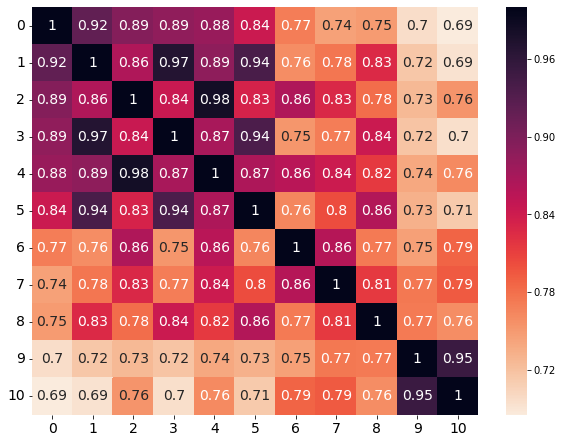

In [35]:
# Representing the Graphlet Correlation Matrix
f, ax = plt.subplots(figsize=(10, 7.5))
hm = sns.heatmap(PosTF_CorrMat, annot=True, ax=ax, cmap = sns.cm.rocket_r, annot_kws={"size": 14})
bottom, top = ax.get_ylim()
pos, textvals = plt.yticks()
plt.yticks(np.arange(11)+0.5,(textvals), rotation=0, fontsize="10", va="center")
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(labelsize= 14)
plt.show()

### NegMN and PosMN (MetaNetter) - Network made with MetaNetter's list of transformations

In [36]:
#Reading the network made
NegMN_dir = nx.read_graphml('Net_NGD_MN.graphml')
NegMN = NegMN_dir.to_undirected()

PosMN_dir = nx.read_graphml('Net_PGD_MN.graphml')
PosMN = PosMN_dir.to_undirected()

In [37]:
print('Nº of nodes and edges in directed Negative Grapevine graph: \t', len(NegMN_dir.nodes()), ',\t',len(NegMN_dir.edges()))
print('Nº of nodes and edges in undirected Negative Grapevine graph: \t',len(NegMN.nodes()), ',\t',len(NegMN.edges()))

print('Nº of nodes and edges in directed Positive Grapevine graph: \t', len(PosMN_dir.nodes()), ',\t',len(PosMN_dir.edges()))
print('Nº of nodes and edges in undirected Positive Grapevine graph: \t',len(PosMN.nodes()), ',\t',len(PosMN.edges()))

Nº of nodes and edges in directed Negative Grapevine graph: 	 3629 ,	 1643
Nº of nodes and edges in undirected Negative Grapevine graph: 	 3629 ,	 1643
Nº of nodes and edges in directed Positive Grapevine graph: 	 7026 ,	 10799
Nº of nodes and edges in undirected Positive Grapevine graph: 	 7026 ,	 10799


In [38]:
# Making dicts for the new node names
new_nodes = dict.fromkeys(NegMN.nodes(),0)

for i,j in nx.get_node_attributes(NegMN,'mass').items(): #i is old name, j is mass/new name
    new_nodes[i] = j

# Relabeling nodes
NegMN = nx.relabel_nodes(NegMN, mapping=new_nodes)

In [39]:
# Making dicts for the new node names
new_nodes = dict.fromkeys(PosMN.nodes(),0)

for i,j in nx.get_node_attributes(PosMN,'mass').items(): #i is old name, j is mass/new name
    new_nodes[i] = j

# Relabeling nodes
PosMN = nx.relabel_nodes(PosMN, mapping=new_nodes)

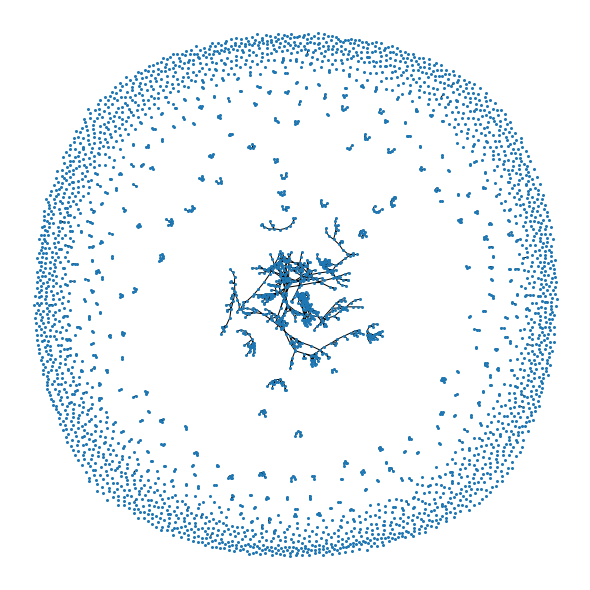

In [40]:
# Drawing the full network for the dataset
plt.figure(figsize=(8,8))
nx.draw(NegMN, node_size=4, width = 1)#, edge_color=edge_colors)
plt.show()

In [41]:
# Spread of components
[len(c) for c in sorted(nx.connected_components(NegMN), key=len, reverse=True)][:20]

[236, 90, 50, 49, 41, 36, 27, 26, 24, 22, 19, 17, 14, 11, 10, 8, 8, 7, 7, 7]

In [42]:
#Diameter and Radius of the Network
Main_component = NegMN.subgraph(list(sorted(nx.connected_components(NegMN), key=len, reverse=True)[0]))
print('Diameter of the network:', nx.diameter(Main_component))
print('Radius of the network:', nx.radius(Main_component))

Diameter of the network: 33
Radius of the network: 17


In [43]:
isolated = 0
for i in NegMN.degree():
    if i[1] == 0:
        isolated = isolated + 1

print('Nº of nodes without connections:', isolated)

Nº of nodes without connections: 2080


#### Plotting the Positive Grapevine Dataset MDiN and Small Characterization of the network - MN

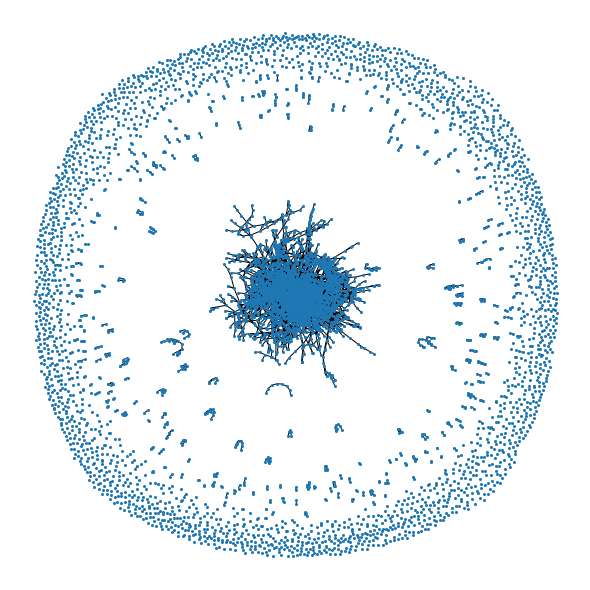

In [44]:
# Drawing the full network for the dataset
plt.figure(figsize=(8,8))
nx.draw(PosMN, node_size=4, width = 1)
plt.show()

In [45]:
# Spread of Components
[len(c) for c in sorted(nx.connected_components(PosMN), key=len, reverse=True)][:20]

[3511, 26, 20, 19, 19, 17, 14, 13, 13, 11, 11, 11, 10, 9, 9, 8, 8, 8, 7, 7]

In [46]:
#Diameter and Radius of the Network
Main_component = PosMN.subgraph(list(sorted(nx.connected_components(PosMN), key=len, reverse=True)[0]))
print('Diameter of the network:', nx.diameter(Main_component))
print('Radius of the network:', nx.radius(Main_component))

Diameter of the network: 36
Radius of the network: 18


In [47]:
isolated = 0
for i in PosMN.degree():
    if i[1] == 0:
        isolated = isolated + 1

print('Nº of nodes without connections:', isolated)

Nº of nodes without connections: 2364


#### Negative Grapevine Dataset Network Analysis with MN transformation list (same analysis that will be done for each individual sample network)

3 measures of centrality: degree, centrality closeness, betweenness centrality.

In [48]:
# Degree
NegMN_degree = dict(NegMN.degree())
NegMN_degree_all = sorted(NegMN_degree.items(), key=lambda kv: kv[1], reverse = True)
NegMN_degree_all[:10]

[(282.2565264522909, 15),
 (344.1113464522909, 13),
 (256.2407064522909, 12),
 (342.0957614522909, 11),
 (328.2619164522909, 11),
 (284.2719864522909, 11),
 (282.2562164522909, 11),
 (242.22514145229096, 10),
 (597.279296452291, 9),
 (356.1113364522909, 9)]

In [49]:
# Betweenness Centrality
NegMN_betw = nx.betweenness_centrality(NegMN)
NegMN_betw_all = sorted(NegMN_betw.items(), key=lambda kv: kv[1], reverse = True)
NegMN_betw_all[:10]

[(346.1635314522909, 0.001699588947028196),
 (320.0538664522909, 0.0015341858055264285),
 (365.0511764522909, 0.0014993279112015716),
 (336.0852814522909, 0.001475028872422519),
 (386.1949664522909, 0.001300259690201718),
 (374.1584564522909, 0.0012918772171727861),
 (324.1942864522909, 0.0012773243914546329),
 (295.1913164522909, 0.0012601495156533034),
 (267.1600164522909, 0.0012548298638564313),
 (228.13664645229093, 0.0010997240164647784)]

In [50]:
# Closeness Centrality
NegMN_closeness = nx.closeness_centrality(NegMN)
NegMN_closeness_all = sorted(NegMN_closeness.items(), key=lambda kv: kv[1], reverse = True)
NegMN_closeness_all[:10]

[(344.1113464522909, 0.009287300388208315),
 (356.1113364522909, 0.009191959744126465),
 (370.1271264522909, 0.00916981044353821),
 (300.1212014522909, 0.009153268392226957),
 (346.1268064522909, 0.009147767629972011),
 (300.12162145229087, 0.009142273475239297),
 (326.1006664522909, 0.009125830537334189),
 (326.1010564522909, 0.009093121467307902),
 (372.1427964522909, 0.009055256000162657),
 (356.11173145229094, 0.009044495149300908)]

MDB Influence calculation

In [51]:
# MDB Influence in building the network
NegMN_MDBs = dict.fromkeys(set(nx.get_edge_attributes(NegMN, 'Transformation').values()), 0)
for i in NegMN.edges():
    NegMN_MDBs[NegMN.edges()[i]['Transformation']] = NegMN_MDBs[NegMN.edges()[i]['Transformation']] + 1

NegMN_MDBs

{'acetone (-H)': 19,
 'CHO2': 21,
 'Carboxylation': 61,
 'methanol (-H2O)': 173,
 'urea addition (-H)': 13,
 'phosphate': 9,
 'primary amine': 28,
 'C2H2': 82,
 'CO2H2': 71,
 'Formic Acid (-H2O)': 111,
 'tertiary amine': 46,
 'acetylation (-H)': 12,
 'carbamoyl P transfer (-H2PO4)': 18,
 'Inorganic Phosphate': 3,
 '"Ethanol (-H2O), ethyl addition (-H2O)"': 261,
 'isoprene addition (-H)': 13,
 'glyoxylate (-H2O)': 24,
 'condensation/dehydration': 58,
 'PolyamineReactionA': 15,
 'hydroxylation (-H)': 135,
 'Acetyl CoA + H2O (-CoASH)': 61,
 'Mevalonate-5-pyrophosphate decarboxylase ': 14,
 'Ethanolamine (-H2O)': 14,
 'Polyamine Synthase': 17,
 'sulfate (-H2O)': 9,
 'hydrogenation/dehydrogenation': 138,
 '"acetylation (-H2O), ketol group (-H2O)"': 39,
 'Aminotransferase': 120,
 'Glycine': 21,
 'secondary amine': 37}

GCD-11 Analysis - Graphlet Correlation Distance of 11 different orbits (maximum of 4-node graphlets)

In [52]:
# Counting the number of the number of times each node has each of the 11 orbits, make it a DataFrame
NegMN_GCD = calculating_orbits(NegMN)
NegMN_GCD_df = pd.DataFrame.from_dict(NegMN_GCD).T

# Graphlet Correlation Matrix (Spearman correlation between the different columns - orbits)
NegMN_CorrMat = stats.spearmanr(NegMN_GCD_df,axis=0)[0]

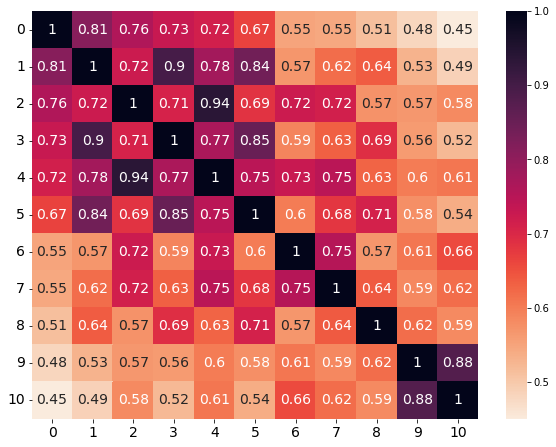

In [53]:
# Representing the Graphlet Correlation Matrix
f, ax = plt.subplots(figsize=(10, 7.5))
hm = sns.heatmap(NegMN_CorrMat, annot=True, ax=ax, cmap = sns.cm.rocket_r, annot_kws={"size": 14})
bottom, top = ax.get_ylim()
pos, textvals = plt.yticks()
plt.yticks(np.arange(11)+0.5,(textvals), rotation=0, fontsize="10", va="center")
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(labelsize= 14)
plt.show()

#### Positive Grapevine Dataset Network Analysis with MN transformation list (same analysis that will be done for each individual sample network)

3 measures of centrality: degree, centrality closeness, betweenness centrality.

In [54]:
# Degree
PosMN_degree = dict(PosMN.degree())
PosMN_degree_all = sorted(PosMN_degree.items(), key=lambda kv: kv[1], reverse = True)
PosMN_degree_all[:10]

[(339.34932354770905, 27),
 (308.1955135477091, 25),
 (248.13813354770906, 25),
 (232.02529854770907, 25),
 (280.1279935477091, 24),
 (264.2194735477091, 23),
 (310.1385735477091, 22),
 (292.12791354770906, 22),
 (266.11228354770907, 22),
 (264.1328035477091, 22)]

In [55]:
# Betweenness Centrality
PosMN_betw = nx.betweenness_centrality(PosMN)
PosMN_betw_all = sorted(PosMN_betw.items(), key=lambda kv: kv[1], reverse = True)
PosMN_betw_all[:10]

[(346.17782354770907, 0.02173147898552824),
 (289.1197985477091, 0.020993755371191202),
 (232.06176854770908, 0.019781991942653544),
 (315.2039135477091, 0.011777301060849767),
 (568.400963547709, 0.010564280937185276),
 (540.369968547709, 0.010458111292915961),
 (370.0932885477091, 0.009143806243501482),
 (303.2529185477091, 0.008337984012953038),
 (329.15118854770907, 0.008232146007706425),
 (314.1034535477091, 0.008180069682656978)]

In [56]:
# Closeness Centrality
PosMN_closeness = nx.closeness_centrality(PosMN)
PosMN_closeness_all = sorted(PosMN_closeness.items(), key=lambda kv: kv[1], reverse = True)
PosMN_closeness_all[:10]

[(376.28242354770913, 0.07453254949765047),
 (320.2321135477091, 0.0737675986236946),
 (348.2636885477091, 0.07352328385023751),
 (386.2340385477091, 0.07337255834991696),
 (414.2289935477091, 0.07335721293678484),
 (348.2770035477091, 0.07328670663099521),
 (379.26938854770907, 0.07283321108350493),
 (345.2638135477091, 0.07276672709346978),
 (432.2393735477091, 0.07275767049783086),
 (303.2529185477091, 0.0727063923419309)]

MDB Influence calculation

In [57]:
# MDB Influence in building the network
PosMN_MDBs = dict.fromkeys(set(nx.get_edge_attributes(PosMN, 'Transformation').values()), 0)
for i in PosMN.edges():
    PosMN_MDBs[PosMN.edges()[i]['Transformation']] = PosMN_MDBs[PosMN.edges()[i]['Transformation']] + 1

PosMN_MDBs

{'CHO2': 68,
 'acetone (-H)': 80,
 'Carboxylation': 386,
 'methanol (-H2O)': 1229,
 'urea addition (-H)': 128,
 'phosphate': 114,
 'primary amine': 121,
 'C2H2': 646,
 'CO2H2': 543,
 'Formic Acid (-H2O)': 612,
 'tertiary amine': 115,
 'acetylation (-H)': 75,
 'carbamoyl P transfer (-H2PO4)': 128,
 'Inorganic Phosphate': 84,
 '"Ethanol (-H2O), ethyl addition (-H2O)"': 1254,
 'isoprene addition (-H)': 77,
 'glyoxylate (-H2O)': 281,
 'condensation/dehydration': 735,
 'PolyamineReactionA': 131,
 'hydroxylation (-H)': 821,
 'Acetyl CoA + H2O (-CoASH)': 438,
 'Mevalonate-5-pyrophosphate decarboxylase ': 227,
 'Ethanolamine (-H2O)': 141,
 'Polyamine Synthase': 263,
 'sulfate (-H2O)': 121,
 'hydrogenation/dehydrogenation': 763,
 '"acetylation (-H2O), ketol group (-H2O)"': 544,
 'Aminotransferase': 215,
 'Glycine': 202,
 'secondary amine': 257}

GCD-11 Analysis - Graphlet Correlation Distance of 11 different orbits (maximum of 4 node graphlets)

In [58]:
# Counting the number of the number of times each node has each of the 11 orbits, make it a DataFrame
PosMN_GCD = calculating_orbits(PosMN)
PosMN_GCD_df = pd.DataFrame.from_dict(PosMN_GCD).T

# Graphlet Correlation Matrix (Spearman correlation between the different columns - orbits)
PosMN_CorrMat = stats.spearmanr(PosMN_GCD_df,axis=0)[0]

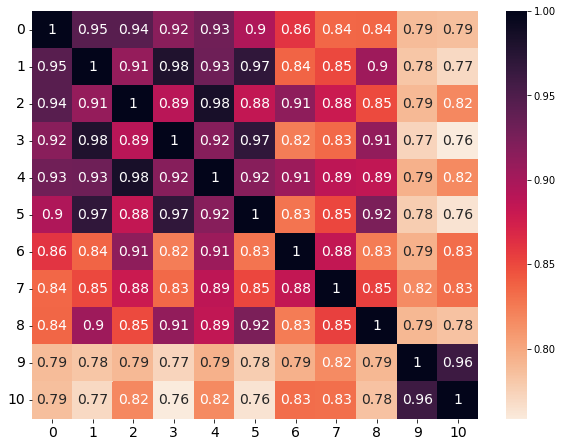

In [59]:
# Representing the Graphlet Correlation Matrix
f, ax = plt.subplots(figsize=(10, 7.5))
hm = sns.heatmap(PosMN_CorrMat, annot=True, ax=ax, cmap = sns.cm.rocket_r, annot_kws={"size": 14})
bottom, top = ax.get_ylim()
pos, textvals = plt.yticks()
plt.yticks(np.arange(11)+0.5,(textvals), rotation=0, fontsize="10", va="center")
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(labelsize= 14)
plt.show()

### Fast Comparison between networks made with the two lists in terms of number of edges

In [60]:
print('Negative Grapevine Dataset - TF edges:', len(NegTF.edges()), 'with 15 transformations.')
print('Negative Grapevine Dataset - MN edges:', len(NegMN.edges()), 'with 30 transformations.')
print(len(NegMN.edges())/len(NegTF.edges())*100 - 100, '% more edges with almost double (100%) the number of groups.')

Negative Grapevine Dataset - TF edges: 1005 with 15 transformations.
Negative Grapevine Dataset - MN edges: 1643 with 30 transformations.
63.48258706467661 % more edges with almost double (100%) the number of groups.


In [61]:
print('Positive Grapevine Dataset - TF edges:', len(PosTF.edges()), 'with 15 transformations.')
print('Positive Grapevine Dataset - MN edges:', len(PosMN.edges()), 'with 30 transformations.')
print(len(PosMN.edges())/len(PosTF.edges())*100 - 100, '% more edges with almost double (100%) the number of groups.')

Positive Grapevine Dataset - TF edges: 6597 with 15 transformations.
Positive Grapevine Dataset - MN edges: 10799 with 30 transformations.
63.695619220857964 % more edges with almost double (100%) the number of groups.


### Why only a network for each dataset instead of a network for each sample?

The different sample networks here will be made of subgraphs of the full dataset network made (one for each transformation list) with only the masses that are present in each sample. This can be done since edges only depend on the two nodes they connect. 

As was observed in the Sample_MDiNs_Yeast.ipynb, this is identical to building the networks from scratch.

## Mass-Difference Sample Networks Analysis and Comparison - NegTF, NegMN, PosTF and PosMN

Here the Sample MDiNs will be analysed by different metrics and a "secondary" dataset will be built for each  different metric with features related to the metric used.

#### Creating the networks by inducing subgraphs of the main networks (each has a dictionary)

Also adding the intensity to store in the respective nodes of each sample network.

In [62]:
aligned_all_pos = aligned_all_pos.replace({np.nan:0})
aligned_all_neg = aligned_all_neg.replace({np.nan:0})

In [63]:
# Making all the sample MDiNs and storing
TF_neg = {}
TF_pos = {}
MN_neg = {}
MN_pos = {}

for n in aligned_all_neg.columns:
    j = n[0] + n[1]
    TF_neg[j] = NegTF.subgraph(aligned_all_neg[aligned_all_neg.loc[:,n] != 0].index)
    TF_pos[j] = PosTF.subgraph(aligned_all_pos[aligned_all_pos.loc[:,n] != 0].index)
    
    MN_neg[j] = NegMN.subgraph(aligned_all_neg[aligned_all_neg.loc[:,n] != 0].index)# + electron_mass)
    MN_pos[j] = PosMN.subgraph(aligned_all_pos[aligned_all_pos.loc[:,n] != 0].index)# - electron_mass)  
    
    #Storing intensity of feature in sample on the nodes - Negative
    intensity_attr = dict.fromkeys(TF_neg[j].nodes(),0)
    for i,m in nx.get_node_attributes(TF_neg[j],'mass').items():
        intensity_attr[i] = {'intensity':aligned_all_neg.loc[m,n]}
    nx.set_node_attributes(TF_neg[j],intensity_attr)
    nx.set_node_attributes(MN_neg[j],intensity_attr)

    #Storing intensity of feature in sample on the nodes - Positive
    intensity_attr = dict.fromkeys(TF_pos[j].nodes(),0)
    for i,m in nx.get_node_attributes(TF_pos[j],'mass').items():
        intensity_attr[i] = {'intensity':aligned_all_pos.loc[m,n]}
    nx.set_node_attributes(TF_pos[j],intensity_attr)
    nx.set_node_attributes(MN_pos[j],intensity_attr)
    
    #print(len(TF[j].nodes()),len(MN[j].nodes()))

Storing all the different analysis measures

In [64]:
# TF
# Storage for the centrality measures results
TF_neg_degree = {} 
TF_neg_betw = {}
TF_neg_closeness = {}

# Storage for the information on group influence and size of components
TF_neg_MDBs = {}
TF_neg_components = {}

# MN
# Storage for the centrality measures results
MN_neg_degree = {} 
MN_neg_betw = {}
MN_neg_closeness = {}

# Storage for the information on group influence and size of components
MN_neg_MDBs = {}
MN_neg_components = {}

# Storing the main centrality measures, size of the different components, group influence and heat diffusions
for j in TF_neg:
    
    # NegTF
    # Centrality measures
    TF_neg_degree[j] = dict(TF_neg[j].degree())
    TF_neg_betw[j] = nx.betweenness_centrality(TF_neg[j])
    TF_neg_closeness[j] = nx.closeness_centrality(TF_neg[j])
    
    # MDB influence
    TF_neg_MDBs[j] = dict.fromkeys(MDBs, 0) # MDBs from the transformation list
    for i in TF_neg[j].edges():
        TF_neg_MDBs[j][TF_neg[j].edges()[i]['Transformation']] = TF_neg_MDBs[j][TF_neg[j].edges()[i]['Transformation']] + 1
    
    # Only get the components > 1 (more than just an isolated node)
    TF_neg_components[j] = [len(c) for c in sorted(nx.connected_components(TF_neg[j]), key=len, reverse=True) if len(c) > 1]
    
    # NegMN
    # Centrality measures
    MN_neg_degree[j] = dict(MN_neg[j].degree())
    MN_neg_betw[j] = nx.betweenness_centrality(MN_neg[j])
    MN_neg_closeness[j] = nx.closeness_centrality(MN_neg[j])
    
    # MDB influence
    MN_neg_MDBs[j] = dict.fromkeys(set(nx.get_edge_attributes(NegMN, 'Transformation').values()), 0)
    for i in MN_neg[j].edges():
        MN_neg_MDBs[j][MN_neg[j].edges()[i]['Transformation']] = MN_neg_MDBs[j][MN_neg[j].edges()[i]['Transformation']] + 1
    
    # Only get the components > 1 (more than just an isolated node)
    MN_neg_components[j] = [len(c) for c in sorted(nx.connected_components(MN_neg[j]), key=len, reverse=True) if len(c) > 1]

    print(j, 'is done')

CAN14 is done
CAN15 is done
CAN16 is done
CS29 is done
CS30 is done
CS31 is done
LAB8 is done
LAB9 is done
LAB10 is done
PN23 is done
PN24 is done
PN25 is done
REG38 is done
REG39 is done
REG40 is done
RIP17 is done
RIP18 is done
RIP19 is done
RL26 is done
RL27 is done
RL28 is done
ROT20 is done
ROT21 is done
ROT22 is done
RU35 is done
RU36 is done
RU37 is done
SYL11 is done
SYL12 is done
SYL13 is done
TRI32 is done
TRI33 is done
TRI34 is done


In [65]:
# TF
# Storage for the centrality measures results
TF_pos_degree = {} 
TF_pos_betw = {}
TF_pos_closeness = {}

# Storage for the information on group influence and size of components
TF_pos_MDBs = {}
TF_pos_components = {}

# MN
# Storage for the centrality measures results
MN_pos_degree = {} 
MN_pos_betw = {}
MN_pos_closeness = {}

# Storage for the information on group influence and size of components
MN_pos_MDBs = {}
MN_pos_components = {}

#Storing the main centrality measures, size of the different components, group influence and heat diffusions
for j in TF_pos:
    
    # PosTF
    # Centrality measures
    TF_pos_degree[j] = dict(TF_pos[j].degree())
    TF_pos_betw[j] = nx.betweenness_centrality(TF_pos[j])
    TF_pos_closeness[j] = nx.closeness_centrality(TF_pos[j])
    
    # MDB influence
    TF_pos_MDBs[j] = dict.fromkeys(MDBs, 0) # MDBs from the transformation list
    for i in TF_pos[j].edges():
        TF_pos_MDBs[j][TF_pos[j].edges()[i]['Transformation']] = TF_pos_MDBs[j][TF_pos[j].edges()[i]['Transformation']] + 1
    
    # Only get the components > 1 (more than just an isolated node)
    TF_pos_components[j] = [len(c) for c in sorted(nx.connected_components(TF_pos[j]), key=len, reverse=True) if len(c) > 1]
    
    # PosMN
    # Centrality measures
    MN_pos_degree[j] = dict(MN_pos[j].degree())
    MN_pos_betw[j] = nx.betweenness_centrality(MN_pos[j])
    MN_pos_closeness[j] = nx.closeness_centrality(MN_pos[j])
    
    # MDB influence
    MN_pos_MDBs[j] = dict.fromkeys(set(nx.get_edge_attributes(PosMN, 'Transformation').values()), 0)
    for i in MN_pos[j].edges():
        MN_pos_MDBs[j][MN_pos[j].edges()[i]['Transformation']] = MN_pos_MDBs[j][MN_pos[j].edges()[i]['Transformation']] + 1
    
    # Only get the components > 1 (more than just an isolated node)
    MN_pos_components[j] = [len(c) for c in sorted(nx.connected_components(MN_pos[j]), key=len, reverse=True) if len(c) > 1]

    print(j, 'is done')

CAN14 is done
CAN15 is done
CAN16 is done
CS29 is done
CS30 is done
CS31 is done
LAB8 is done
LAB9 is done
LAB10 is done
PN23 is done
PN24 is done
PN25 is done
REG38 is done
REG39 is done
REG40 is done
RIP17 is done
RIP18 is done
RIP19 is done
RL26 is done
RL27 is done
RL28 is done
ROT20 is done
ROT21 is done
ROT22 is done
RU35 is done
RU36 is done
RU37 is done
SYL11 is done
SYL12 is done
SYL13 is done
TRI32 is done
TRI33 is done
TRI34 is done


### 3 Centrality measures, MDB Influence and GCD-11 analysis

The 3 first network analysis methods focus on the characteristics of each node and each node is kept as a feature of a new dataset while the last 3 methods focus on the overall topology and structure of the network reducing drastically the number of features. By analysing in both manners, we obtained a more complete analysis of the networks and can be more confident in our results. 

### Obtaining the dataframes for analysis

#### Centrality measures dataframes

The analysis of each centrality measure is completely independent of each other.

In [66]:
# Negative GD TF
degree_neg_TF = pd.DataFrame.from_dict(TF_neg_degree).replace({np.nan:0})
betw_neg_TF = pd.DataFrame.from_dict(TF_neg_betw).replace({np.nan:0.0})
closeness_neg_TF = pd.DataFrame.from_dict(TF_neg_closeness).replace({np.nan:0.0})

In [67]:
# Positive GD TF
degree_pos_TF = pd.DataFrame.from_dict(TF_pos_degree).replace({np.nan:0})
betw_pos_TF = pd.DataFrame.from_dict(TF_pos_betw).replace({np.nan:0.0})
closeness_pos_TF = pd.DataFrame.from_dict(TF_pos_closeness).replace({np.nan:0.0})

In [68]:
# Negative GD MN
degree_neg_MN = pd.DataFrame.from_dict(MN_neg_degree).replace({np.nan:0})
betw_neg_MN = pd.DataFrame.from_dict(MN_neg_betw).replace({np.nan:0.0})
closeness_neg_MN = pd.DataFrame.from_dict(MN_neg_closeness).replace({np.nan:0.0})

In [69]:
# Positive GD MN
degree_pos_MN = pd.DataFrame.from_dict(MN_pos_degree).replace({np.nan:0})
betw_pos_MN = pd.DataFrame.from_dict(MN_pos_betw).replace({np.nan:0.0})
closeness_pos_MN = pd.DataFrame.from_dict(MN_pos_closeness).replace({np.nan:0.0})

In [70]:
# Example of a centrality measure dataframe
degree_pos_TF

,CAN14,CAN15,CAN16,CS29,CS30,CS31,LAB8,LAB9,LAB10,PN23,...,ROT22,RU35,RU36,RU37,SYL11,SYL12,SYL13,TRI32,TRI33,TRI34
408.174674,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
408.304004,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,1.0,3.0,...,1.0,3.0,3.0,1.0,1.0,1.0,1.0,3.0,2.0,1.0
409.307374,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
410.235899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
410.423154,0.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,...,1.0,4.0,4.0,4.0,1.0,1.0,1.0,3.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470.176529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
476.397174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498.551454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
500.516539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### MDB Influence Dataframes

Transform the dictionary of dictionaries with the MDB Influence stats into a dataframe. Now, it can be analysed together with the binary dataframes made above. The analysis performed will be the same than for the rest of dataframes, however, for this dataframe the distance measure used in hierarchical clustering is euclidean and not a binary measure such as the jaccard distance since this dataframe is not binary.

#### What is "MDB Influence" in this context?

Each MDB that represents a set of chemical reactions has a value attached in every network built. This number corresponds to the amount of edges that were established between two formulas that used this MDB, that is, the amount of times one of the set of chemical reactions can transform a formula into another (a metabolite into another).

This value then should represent the importance of the MDB in establishing the network when compared to the rest of the groups. The bigger the value, the higher the impact of that MDB in establishing the network. To normalize the comparison between sample MDiNs with a lot and few edges, the MDBs values are normalized by the total number of edges established in the network (and multiplied by 100). Then, they represent the % of edges each MDB helped establish.

Here we test if the importance of these MDBs in establishing the overall network is characteristic of the strain of the sample.

We also can see the overall influence of each MDB in building the networks. 

In [71]:
MDBs_neg_TF = pd.DataFrame.from_dict(TF_neg_MDBs)
MDBs_neg_MN = pd.DataFrame.from_dict(MN_neg_MDBs)
MDBs_pos_TF = pd.DataFrame.from_dict(TF_pos_MDBs)
MDBs_pos_MN = pd.DataFrame.from_dict(MN_pos_MDBs)
MDBs_pos_TF

,CAN14,CAN15,CAN16,CS29,CS30,CS31,LAB8,LAB9,LAB10,PN23,...,ROT22,RU35,RU36,RU37,SYL11,SYL12,SYL13,TRI32,TRI33,TRI34
H2,24,37,26,55,58,64,35,37,34,125,...,16,146,145,163,47,11,26,135,135,158
CH2,68,110,74,119,118,137,120,119,110,238,...,43,270,259,308,110,65,74,219,237,292
CO2,9,14,12,22,30,25,17,10,12,56,...,7,68,59,74,14,3,6,57,58,74
O,15,31,18,56,54,70,30,30,30,128,...,19,160,149,187,40,15,22,134,152,163
CHOH,0,3,1,5,2,3,1,1,1,8,...,0,8,12,11,1,0,1,10,5,10
NCH,4,10,7,13,16,20,7,6,11,33,...,5,49,49,60,4,5,5,30,35,40
O(-NH),4,8,4,20,16,19,5,4,10,40,...,2,49,45,54,10,2,3,36,41,48
S,0,4,0,1,1,0,6,8,4,8,...,1,8,9,8,2,0,2,11,8,12
CONH,1,2,0,3,5,4,6,4,4,36,...,2,33,28,37,7,3,4,15,19,32
PO3H,1,4,0,5,3,6,3,2,5,6,...,0,5,8,9,4,2,2,7,5,11


In [72]:
# Normalization of the MDBs
MDBs_neg_TF = MDBs_neg_TF/MDBs_neg_TF.sum()*100
MDBs_pos_TF = MDBs_pos_TF/MDBs_pos_TF.sum()*100

MDBs_neg_MN = MDBs_neg_MN/MDBs_neg_MN.sum()*100
MDBs_pos_MN = MDBs_pos_MN/MDBs_pos_MN.sum()*100

### GCD-11 Analysis - Graphlet Correlation Distance of 11 different orbits (maximum of 4 node graphlets) - (Needs verification)

#### Very quick explanation

This methods considers 11 of the 15 possible orbits (since the other 4 are redundant - 3, 12, 13, 14) of 2 to 4-node graphlets - check image below. Nodes with the same colour in the same graphlet are 'automorphic' in the sense that they are in the 'same' relative position.  5-node graphlets were excluded to diminish dependencies between graphlets which add noise (according to the authors - 1st paper below). With these orbits, we can build a Graphlet Degree Vector for each node that is composed by the number of times a node is present in each of the 11 types of orbits. These are the rows of a Dataframe with 11 columns (for one network). This is what the calculating_orbits function does (except it returns a dict of dicts instead of a dataframe).

From this dataframe, the spearman correlation between each pair of the 11 columns is calculated to generate a 11x11 matrix - the Graphlet Correlation Matrix (GCM). The GCM is symmetric so only one half of the matrix is informative. This, according to the authors, is the signature of the network topology by this method (since networks with different kinds of connections/topologies will have different patterns of orbits and therefore correlations - stored in G_corrMat. The usual distance calculation between the different 'signatures' can then give the distance between the different networks which is ideal to build directly a dendrogram.

However, unlike what was done for the heat diffusion, we don't want a distance matrix to be our dataset for supervised methods. So, a dataset was made where the GCM signature of each network was fully maintained by making a columns from the informative half of the GCM where each row has the name 'n-m' where n and m are the names of orbits and the value in that row is the spearman correlation between those two orbits in the network. This makes it so every network is reduced to a dataset of just 60 features that simbolize the topology of said network.

Useful papers for detailed explanations: 
- Revealing the Hidden Language of Complex Networks - GCD-11 - probably the best one
- Uncovering Biological Network Function via Graphlet Degree Signatures - some details on graphlet signatures
- Comparing methods for comparing networks - many different methods

<img src="Graphlets.png" width="800">

In [73]:
TF_neg_CorrMat = {}
for i in TF_neg:
    # For 1 network
    orbits_t = calculating_orbits(TF_neg[i]) # Calculating orbit number for each node
    orbits_df = pd.DataFrame.from_dict(orbits_t).T # Transforming into a dataframe
    
    corrMat_ar = stats.spearmanr(orbits_df)[0] # Calculating spearman correlation to obtain 11x11 signature of the network - GCM
    corrMat_ar[np.isnan(corrMat_ar)] = 0 # Some orbits aren't present in some networks - make correlation zero
    TF_neg_CorrMat[i] = np.triu(corrMat_ar) # Both parts of the matrix are equal, so reducing the info to the upper triangle

C:\Users\francisco\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\francisco\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\francisco\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\francisco\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\francisco\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [74]:
# Pulling the signature orbit n (u) - orbit m (v) correlations from the upper triangular matrix of the GCM
TF_neg_CorrMat_df = {}
orbits = [0,1,2,4,5,6,7,8,9,10,11] # orbit names

# Making the signature into a column of the secondary dataset
for i in TF_neg_CorrMat:
    samp_col = {}
    for u in range(len(TF_neg_CorrMat[i])):
        for v in range(u+1, len(TF_neg_CorrMat[i])):
            samp_col[str(orbits[u]) + '-' + str(orbits[v])] = TF_neg_CorrMat[i][u,v]
        TF_neg_CorrMat_df[i] = samp_col

# Each row of the dataframe will be orbit_u-orbit_v correlation
corrMat_neg_TF = pd.DataFrame.from_dict(TF_neg_CorrMat_df)
#corrMat_neg_TF

In [75]:
TF_pos_CorrMat = {}
for i in MN_pos:
    #For 1 network
    orbits_t = calculating_orbits(TF_pos[i]) # Calculating orbit number for each node
    orbits_df = pd.DataFrame.from_dict(orbits_t).T # Transforming into a dataframe
    
    corrMat_ar = stats.spearmanr(orbits_df)[0] # Calculating spearman correlation to obtain 11x11 signature of the network - GCM
    corrMat_ar[np.isnan(corrMat_ar)] = 0 # Some orbits aren't present in some networks - make correlation zero
    TF_pos_CorrMat[i] = np.triu(corrMat_ar) # Both parts of the matrix are equal, so reducing the info to the upper triangle

In [76]:
# Pulling the signature orbit n (u) - orbit m (v) correlations from the upper triangular matrix of the GCM
TF_pos_CorrMat_df = {}
orbits = [0,1,2,4,5,6,7,8,9,10,11] # orbit names

# Making the signature into a column of the secondary dataset
for i in TF_pos_CorrMat:
    samp_col = {}
    for u in range(len(TF_pos_CorrMat[i])):
        for v in range(u+1, len(TF_pos_CorrMat[i])):
            samp_col[str(orbits[u]) + '-' + str(orbits[v])] = TF_pos_CorrMat[i][u,v]
        TF_pos_CorrMat_df[i] = samp_col

# Each row of the dataframe will be orbit_u-orbit_v correlation
corrMat_pos_TF = pd.DataFrame.from_dict(TF_pos_CorrMat_df)
#corrMat_TF_pos

In [77]:
MN_neg_CorrMat = {}
for i in MN_neg:
    #For 1 network
    orbits_t = calculating_orbits(MN_neg[i]) # Calculating orbit number for each node
    orbits_df = pd.DataFrame.from_dict(orbits_t).T # Transforming into a dataframe
    
    corrMat_ar = stats.spearmanr(orbits_df)[0] # Calculating spearman correlation to obtain 11x11 signature of the network - GCM
    corrMat_ar[np.isnan(corrMat_ar)] = 0 # Some orbits aren't present in some networks - make correlation zero
    MN_neg_CorrMat[i] = np.triu(corrMat_ar) # Both parts of the matrix are equal, so reducing the info to the upper triangle

In [78]:
# Pulling the signature orbit n (u) - orbit m (v) correlations from the upper triangular matrix of the GCM
MN_neg_CorrMat_df = {}
orbits = [0,1,2,4,5,6,7,8,9,10,11] # orbit names

# Making the signature into a column of the secondary dataset
for i in MN_neg_CorrMat:
    samp_col = {}
    for u in range(len(MN_neg_CorrMat[i])):
        for v in range(u+1, len(MN_neg_CorrMat[i])):
            samp_col[str(orbits[u]) + '-' + str(orbits[v])] = MN_neg_CorrMat[i][u,v]
        MN_neg_CorrMat_df[i] = samp_col

# Each row of the dataframe will be orbit_u-orbit_v correlation
corrMat_neg_MN = pd.DataFrame.from_dict(MN_neg_CorrMat_df)
corrMat_neg_MN

,CAN14,CAN15,CAN16,CS29,CS30,CS31,LAB8,LAB9,LAB10,PN23,...,ROT22,RU35,RU36,RU37,SYL11,SYL12,SYL13,TRI32,TRI33,TRI34
0-1,0.798421,0.794340,0.769354,0.760594,0.739890,0.758719,0.749683,0.794852,0.836816,0.825151,...,0.815488,0.765804,0.719988,0.708263,0.781929,0.802765,0.788571,0.775780,0.541937,0.746818
0-2,0.656254,0.640459,0.636123,0.631502,0.633932,0.630041,0.602983,0.644594,0.680556,0.723863,...,0.697246,0.629004,0.600015,0.602779,0.672349,0.651105,0.643760,0.651144,0.431238,0.636282
0-4,0.688014,0.614404,0.599173,0.700214,0.670731,0.678111,0.567025,0.641605,0.712796,0.713510,...,0.731867,0.642161,0.636168,0.626271,0.684005,0.679491,0.655380,0.672937,0.350564,0.657215
0-5,0.594490,0.579792,0.540673,0.614004,0.605051,0.599409,0.532753,0.560343,0.632277,0.626325,...,0.674654,0.580813,0.559548,0.545961,0.629177,0.614363,0.587688,0.610193,0.331923,0.602781
0-6,0.580206,0.534030,0.547127,0.594686,0.575964,0.608522,0.495212,0.488718,0.607236,0.634823,...,0.576189,0.444896,0.472872,0.524655,0.581579,0.425574,0.464648,0.559120,0.289913,0.585484
0-7,0.376486,0.349142,0.383195,0.422000,0.407769,0.411693,0.372499,0.330362,0.447592,0.490027,...,0.387878,0.307918,0.316701,0.326058,0.405246,0.283539,0.309015,0.348312,0.195220,0.402100
0-8,0.324474,0.242477,0.290097,0.299825,0.316378,0.326450,0.312841,0.286634,0.307246,0.477313,...,0.364148,0.250253,0.142302,0.219471,0.343181,0.220438,0.271877,0.358139,0.153866,0.394227
0-9,0.551912,0.401522,0.526374,0.530420,0.502332,0.514708,0.458048,0.523022,0.582273,0.498675,...,0.525121,0.339270,0.362766,0.464165,0.523526,0.575975,0.491004,0.467557,0.097505,0.509818
0-10,0.535870,0.438378,0.519066,0.550478,0.500177,0.507549,0.494778,0.511796,0.523638,0.543395,...,0.543367,0.404140,0.420267,0.482911,0.510977,0.577643,0.509077,0.507668,0.136011,0.518764
0-11,0.421707,0.349159,0.427914,0.461817,0.440169,0.428383,0.375718,0.403110,0.463723,0.482595,...,0.468437,0.339750,0.345087,0.398704,0.421629,0.515676,0.424412,0.437639,0.112152,0.436092


In [79]:
MN_pos_CorrMat = {}
for i in MN_pos:
    # For 1 network
    orbits_t = calculating_orbits(MN_pos[i]) # Calculating orbit number for each node
    orbits_df = pd.DataFrame.from_dict(orbits_t).T # Transforming into a dataframe
    
    corrMat_ar = stats.spearmanr(orbits_df)[0] # Calculating spearman correlation to obtain 11x11 signature of the network - GCM
    corrMat_ar[np.isnan(corrMat_ar)] = 0 # Some orbits aren't present in some networks - make correlation zero
    MN_pos_CorrMat[i] = np.triu(corrMat_ar) # Both parts of the matrix are equal, so reducing the info to the upper triangle

In [80]:
# Pulling the signature orbit n (u) - orbit m (v) correlations from the upper triangular matrix of the GCM
MN_pos_CorrMat_df = {}
orbits = [0,1,2,4,5,6,7,8,9,10,11] # orbit names

# Making the signature into a column of the secondary dataset
for i in MN_pos_CorrMat:
    samp_col = {}
    for u in range(len(MN_pos_CorrMat[i])):
        for v in range(u+1, len(MN_pos_CorrMat[i])):
            samp_col[str(orbits[u]) + '-' + str(orbits[v])] = MN_pos_CorrMat[i][u,v]
        MN_pos_CorrMat_df[i] = samp_col

# Each row of the dataframe will be orbit_u-orbit_v correlation
corrMat_pos_MN = pd.DataFrame.from_dict(MN_pos_CorrMat_df)
#corrMat_MN_pos

##### Global metadata for consistency between tables and plots

Finally, only now are the labels of each group added making the dataframe a CDL Accessor.

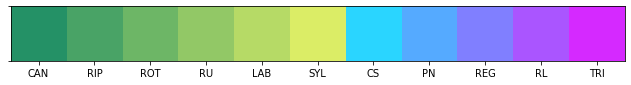

In [81]:
# Adding the labels of the groups to each DataFrame
labels = list(aligned_all_pos.cdl.labels)

mtl.add_labels(degree_neg_TF, labels = labels)
mtl.add_labels(betw_neg_TF, labels = labels)
mtl.add_labels(closeness_neg_TF, labels = labels)
mtl.add_labels(MDBs_neg_TF, labels = labels)
mtl.add_labels(corrMat_neg_TF, labels = labels)

mtl.add_labels(degree_neg_MN, labels = labels)
mtl.add_labels(betw_neg_MN, labels = labels)
mtl.add_labels(closeness_neg_MN, labels = labels)
mtl.add_labels(MDBs_neg_MN, labels = labels)
mtl.add_labels(corrMat_neg_MN, labels = labels)

mtl.add_labels(degree_pos_TF, labels = labels)
mtl.add_labels(betw_pos_TF, labels = labels)
mtl.add_labels(closeness_pos_TF, labels = labels)
mtl.add_labels(MDBs_pos_TF, labels = labels)
mtl.add_labels(corrMat_pos_TF, labels = labels)

mtl.add_labels(degree_pos_MN, labels = labels)
mtl.add_labels(betw_pos_MN, labels = labels)
mtl.add_labels(closeness_pos_MN, labels = labels)
mtl.add_labels(MDBs_pos_MN, labels = labels)
mtl.add_labels(corrMat_pos_MN, labels = labels)

# Useful variables for later on
sample_names = degree_neg_TF.cdl.samples
all_labels = degree_neg_TF.cdl.labels
unique_labels = degree_neg_TF.cdl.unique_labels

# Colours representing each grapevine variety
# customize these colors
colours = sns.color_palette('summer', 6)
colours.extend(sns.color_palette('cool', 5))
ordered_unique_labels = ('CAN','RIP','ROT','RU','LAB','SYL','CS','PN','REG','RL','TRI')

label_colors = {lbl: c for lbl, c in zip(ordered_unique_labels, colours)}

sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(ordered_unique_labels)), ordered_unique_labels)

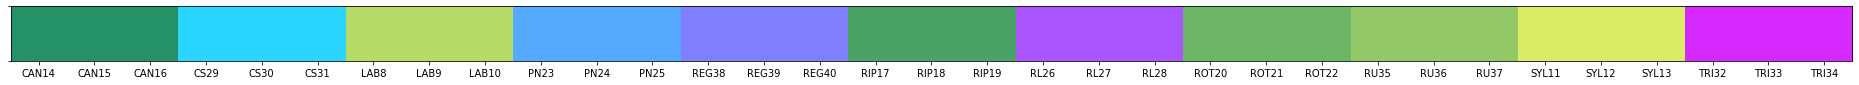

In [82]:
sample_colors = {s: label_colors[lbl] for s, lbl in zip(sample_names, all_labels)}

sns.palplot(sample_colors.values())
new_ticks = plt.xticks(range(len(sample_names)), sample_names)

## Unsupervised and Supervised Statistical Analysis 

### Unsupervised Statistical Analysis

### (Agglomerative) Hierarchical Cluster Analysis 

HCA analysis and plotting dendrograms based on the secondary datasets built - degree, betweenness centrality, closeness centrality, MDB influence and GCD-11 for both the TF and NM networks.

Dendrograms were plotted with Euclidian distance metric and UPGMA linkage.

In [83]:
def plot_dendogram(Z, title='', color_threshold=None):
    """Plot a dendrogram from a Z linkage matrix with a chosen title and a chosen color_threshold."""
    
    plt.rcParams['lines.linewidth'] = 1.3
    
    fig = plt.figure(figsize=(10,6))
    dn = hier.dendrogram(Z, labels=all_labels, leaf_font_size=13, above_threshold_color='b', leaf_rotation=45,
                         color_threshold=color_threshold)#,  orientation='left')
    
    # Coloring labels
    ax = plt.gca()
    ax.set_ylabel('Distance (UA)')
    ax.set_title(title, fontsize = 16)
    xlbls = ax.get_xmajorticklabels()

    for lbl in xlbls:
        lbl.set_color(label_colors[lbl.get_text()])
    

### NegTF - Negative Grapevine Dataset with our Transformation List - Part of Fig. 3.9 and Suppl. Fig 6.9

Centrality measures Dendrograms

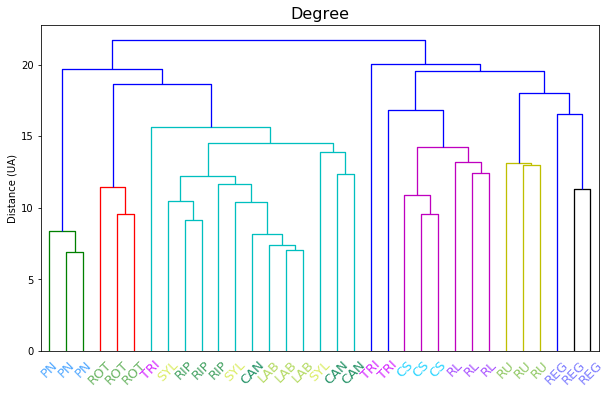

In [84]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
degree_neg_TF_df_dist = dist.pdist(degree_neg_TF.T, metric='euclidean')
Z_degree_neg_TF = hier.linkage(degree_neg_TF_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_degree_neg_TF, degree_neg_TF_df_dist)[0]

# Plot the dendrogram
title = f'Degree'
plot_dendogram(Z_degree_neg_TF, title, color_threshold=16)
#plt.savefig('Net-Dendro-NGD-Degree')

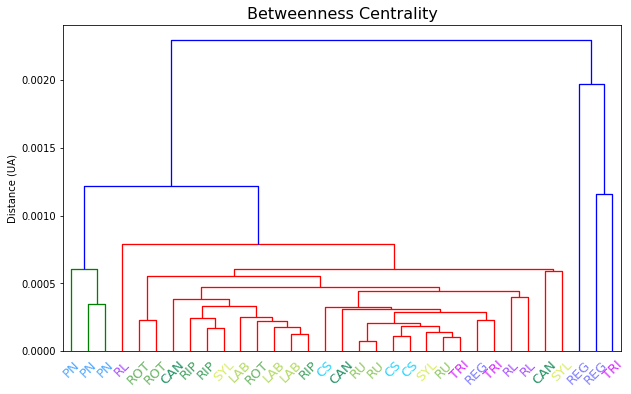

In [85]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
betw_neg_TF_df_dist = dist.pdist(betw_neg_TF.T, metric='euclidean')
Z_betw_neg_TF = hier.linkage(betw_neg_TF_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_betw_neg_TF, betw_neg_TF_df_dist)[0]

# Plot the dendrogram
title = f'Betweenness Centrality'
plot_dendogram(Z_betw_neg_TF, title, color_threshold = 0.001)
#plt.savefig('Net-Dendro-NGD-Betw')

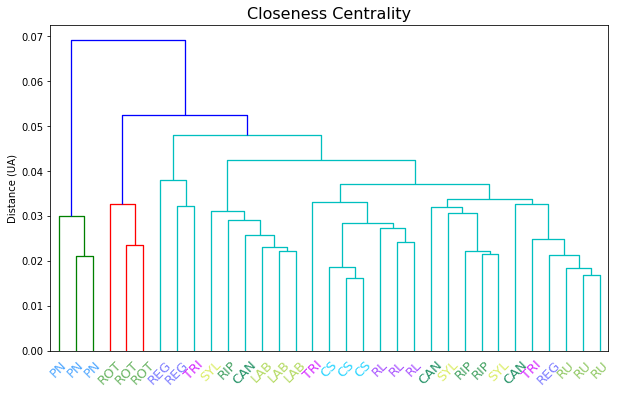

In [86]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
closeness_neg_TF_df_dist = dist.pdist(closeness_neg_TF.T, metric='euclidean')
Z_closeness_neg_TF = hier.linkage(closeness_neg_TF_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_closeness_neg_TF, closeness_neg_TF_df_dist)[0]

# Plot the dendrogram
title = f'Closeness Centrality'
plot_dendogram(Z_closeness_neg_TF, title)
#plt.savefig('Net-Dendro-NGD-Closeness')

MDB Influence Dendrogram

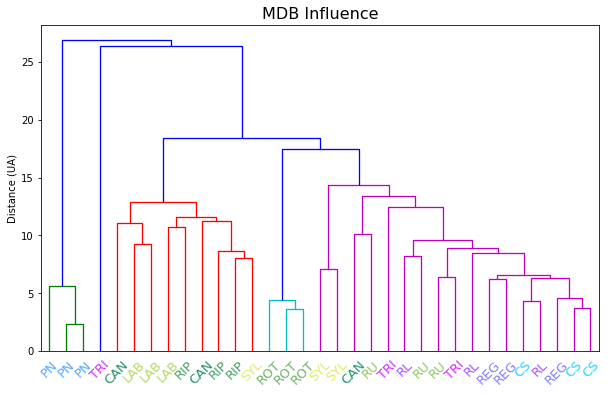

In [87]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
MDBs_neg_TF_df_dist = dist.pdist(MDBs_neg_TF.T, metric='euclidean')
Z_MDBs_neg_TF = hier.linkage(MDBs_neg_TF_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_MDBs_neg_TF, MDBs_neg_TF_df_dist)[0]

# Plot the dendrogram
title = f'MDB Influence'
plot_dendogram(Z_MDBs_neg_TF, title, color_threshold=17)
#plt.savefig('Net-Dendro-NGD-Group')

GCD-11 Dendrogram

In [88]:
# Calculating the distance matrix (between the samples) of the secondary dataset
corrMat_neg_TF_df_dist = dist.pdist(corrMat_neg_TF.T)

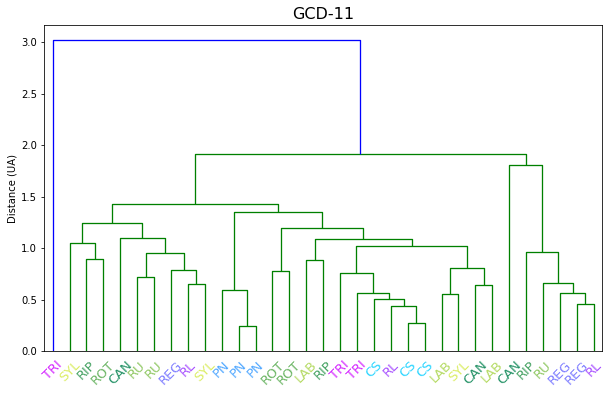

In [89]:
# Build the linkage matrix of the HCA
Z_GCD_neg_TF = hier.linkage(corrMat_neg_TF_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_GCD_neg_TF, corrMat_neg_TF_df_dist)[0]

# Plot the dendrogram
title = f'GCD-11'
plot_dendogram(Z_GCD_neg_TF, title)
#plt.savefig('Net-Dendro-NGD-GCD-11')

### PosTF - Positive Grapevine Dataset with our Transformation List - Part of Fig. 3.9 and Suppl. Fig 6.9

Centrality measures Dendrograms

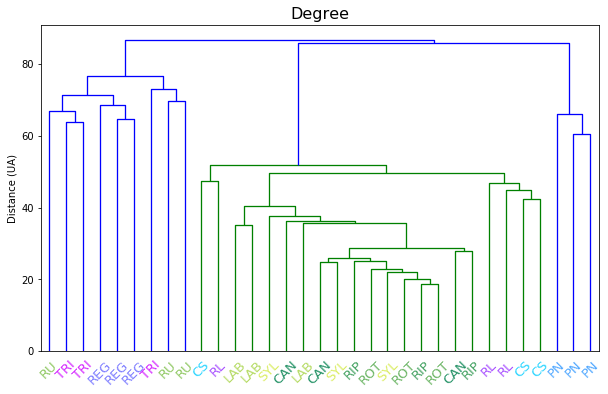

In [90]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
degree_pos_TF_df_dist = dist.pdist(degree_pos_TF.T, metric='euclidean')
Z_degree_pos_TF = hier.linkage(degree_pos_TF_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_degree_pos_TF, degree_pos_TF_df_dist)[0]

# Plot the dendrogram
title = f'Degree'
plot_dendogram(Z_degree_pos_TF, title)
#plt.savefig('Net-Dendro-PGD-degree')

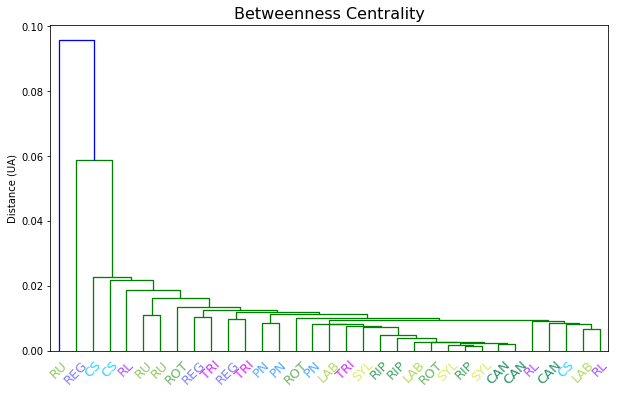

In [91]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
betw_pos_TF_df_dist = dist.pdist(betw_pos_TF.T, metric='euclidean')
Z_betw_pos_TF = hier.linkage(betw_pos_TF_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_betw_pos_TF, betw_pos_TF_df_dist)[0]

# Plot the dendrogram
title = f'Betweenness Centrality'
plot_dendogram(Z_betw_pos_TF, title)
#plt.savefig('Net-Dendro-PGD-betw')

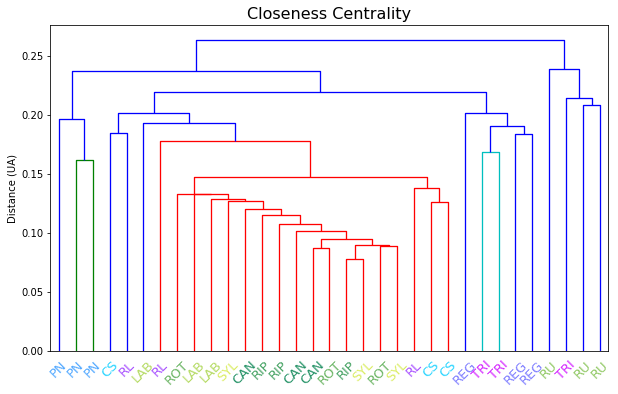

In [92]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
closeness_pos_TF_df_dist = dist.pdist(closeness_pos_TF.T, metric='euclidean')
Z_closeness_pos_TF = hier.linkage(closeness_pos_TF_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_closeness_pos_TF, closeness_pos_TF_df_dist)[0]

# Plot the dendrogram
title = f'Closeness Centrality'
plot_dendogram(Z_closeness_pos_TF, title)
#plt.savefig('Net-Dendro-PGD-closeness')

MDB Influence Dendrogram

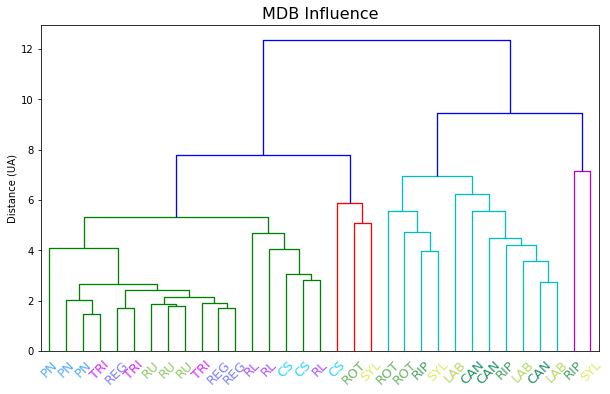

In [93]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
MDBs_pos_TF_df_dist = dist.pdist(MDBs_pos_TF.T, metric='euclidean')
Z_MDBs_pos_TF = hier.linkage(MDBs_pos_TF_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_MDBs_pos_TF, MDBs_pos_TF_df_dist)[0]

# Plot the dendrogram
title = f'MDB Influence'
plot_dendogram(Z_MDBs_pos_TF, title, color_threshold=7.5)
#plt.savefig('Net-Dendro-PGD-group')

GCD-11 Dendrogram

In [94]:
# Calculating the distance matrix (between the samples) of the secondary dataset
corrMat_pos_TF_df_dist = dist.pdist(corrMat_pos_TF.T)

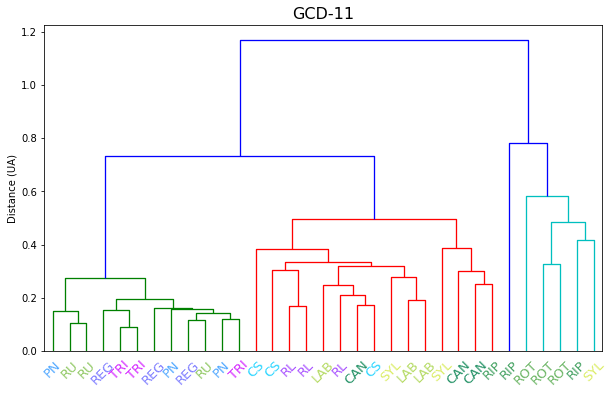

In [95]:
# Build the linkage matrix of the HCA
Z_GCD_pos_TF = hier.linkage(corrMat_pos_TF_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_GCD_pos_TF, corrMat_pos_TF_df_dist)[0]

# Plot the dendrogram
title = f'GCD-11'
plot_dendogram(Z_GCD_pos_TF, title, color_threshold = 0.65)
#plt.savefig('Net-Dendro-PGD-GCD-11')

### NegMN - Negative Grapevine Dataset with MetaNetter's Transformation List

Centrality measures Dendrograms

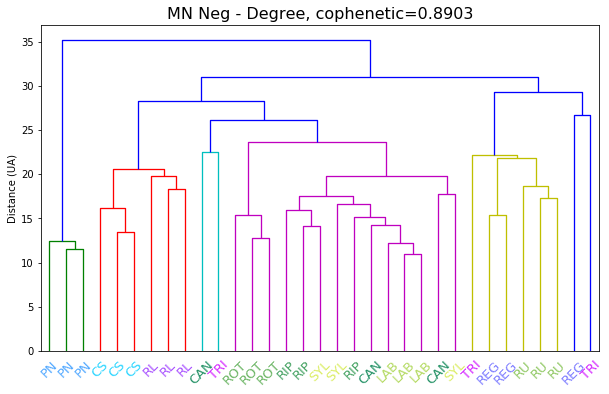

In [96]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
degree_neg_MN_df_dist = dist.pdist(degree_neg_MN.T, metric='euclidean')
Z_degree_neg_MN = hier.linkage(degree_neg_MN_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_degree_neg_MN, degree_neg_MN_df_dist)[0]

# Plot the dendrogram
title = f'MN Neg - Degree, cophenetic={coph:.4f}'
plot_dendogram(Z_degree_neg_MN, title)

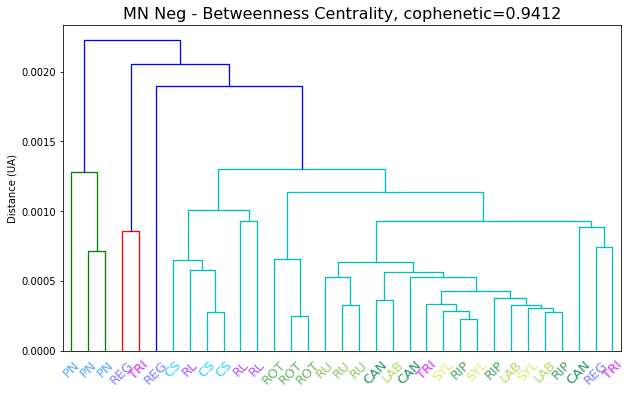

In [97]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
betw_neg_MN_df_dist = dist.pdist(betw_neg_MN.T, metric='euclidean')
Z_betw_neg_MN = hier.linkage(betw_neg_MN_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_betw_neg_MN, betw_neg_MN_df_dist)[0]

# Plot the dendrogram
title = f'MN Neg - Betweenness Centrality, cophenetic={coph:.4f}'
plot_dendogram(Z_betw_neg_MN, title)

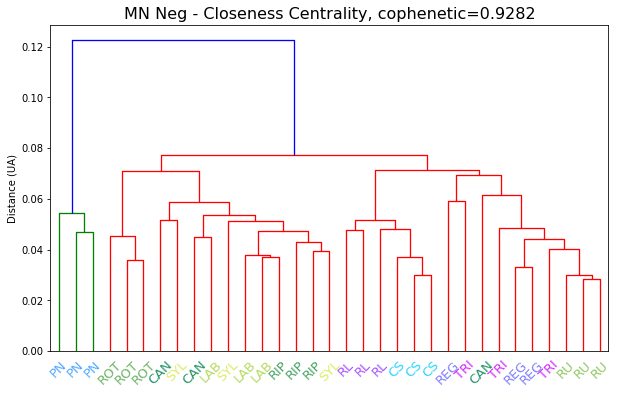

In [98]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
closeness_neg_MN_df_dist = dist.pdist(closeness_neg_MN.T, metric='euclidean')
Z_closeness_neg_MN = hier.linkage(closeness_neg_MN_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_closeness_neg_MN, closeness_neg_MN_df_dist)[0]

# Plot the dendrogram
title = f'MN Neg - Closeness Centrality, cophenetic={coph:.4f}'
plot_dendogram(Z_closeness_neg_MN, title)

MDB Influence Dendrogram

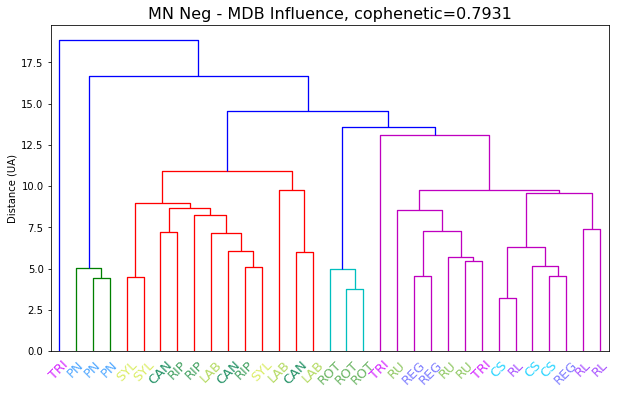

In [99]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
MDBs_neg_MN_df_dist = dist.pdist(MDBs_neg_MN.T, metric='euclidean')
Z_MDBs_neg_MN = hier.linkage(MDBs_neg_MN_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_MDBs_neg_MN, MDBs_neg_MN_df_dist)[0]

# Plot the dendrogram
title = f'MN Neg - MDB Influence, cophenetic={coph:.4f}'
plot_dendogram(Z_MDBs_neg_MN, title)

GCD-11 Dendrogram

In [100]:
# Calculating the distance matrix (distances between the samples) in the secondary dataset
corrMat_neg_MN_df_dist = dist.pdist(corrMat_neg_MN.T)

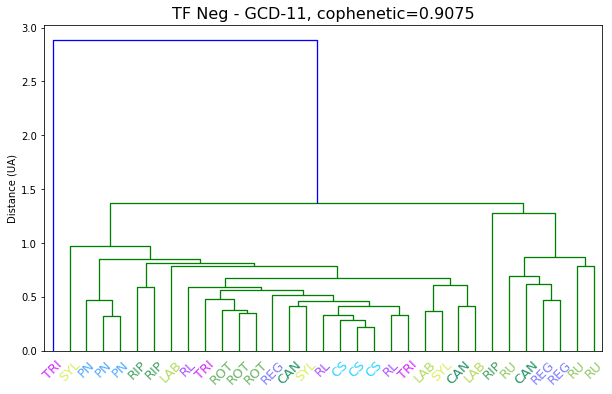

In [101]:
# Build the linkage matrix of the HCA
Z_GCD_neg_MN = hier.linkage(corrMat_neg_MN_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_GCD_neg_MN, corrMat_neg_MN_df_dist)[0]

# Plot the dendrogram
title = f'TF Neg - GCD-11, cophenetic={coph:.4f}'
plot_dendogram(Z_GCD_neg_MN, title)

### PosMN - Positive Grapevine Dataset with MetaNetter's Transformation List

Centrality measures Dendrograms

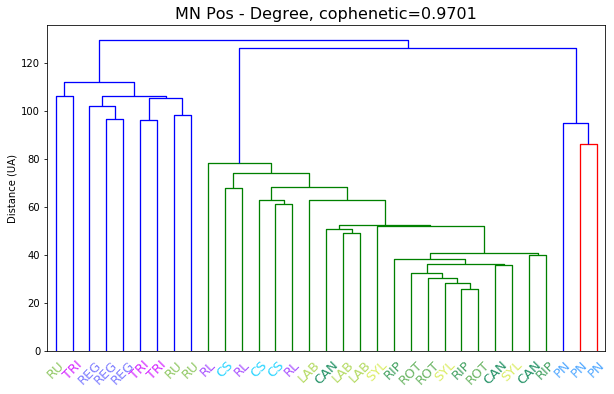

In [102]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
degree_pos_MN_df_dist = dist.pdist(degree_pos_MN.T, metric='euclidean')
Z_degree_pos_MN = hier.linkage(degree_pos_MN_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_degree_pos_MN, degree_pos_MN_df_dist)[0]

# Plot the dendrogram
title = f'MN Pos - Degree, cophenetic={coph:.4f}'
plot_dendogram(Z_degree_pos_MN, title)

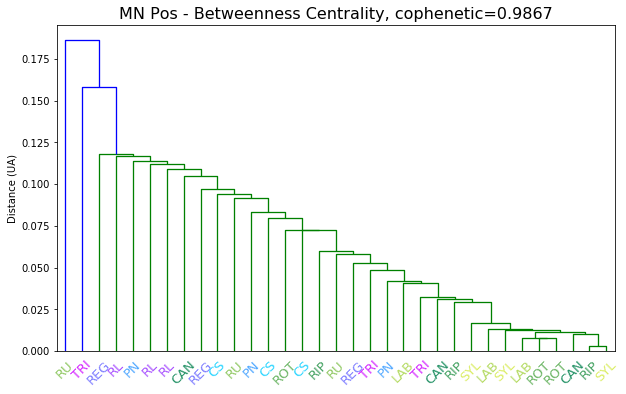

In [103]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
betw_pos_MN_df_dist = dist.pdist(betw_pos_MN.T, metric='euclidean')
Z_betw_pos_MN = hier.linkage(betw_pos_MN_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_betw_pos_MN, betw_pos_MN_df_dist)[0]

# Plot the dendrogram
title = f'MN Pos - Betweenness Centrality, cophenetic={coph:.4f}'
plot_dendogram(Z_betw_pos_MN, title)

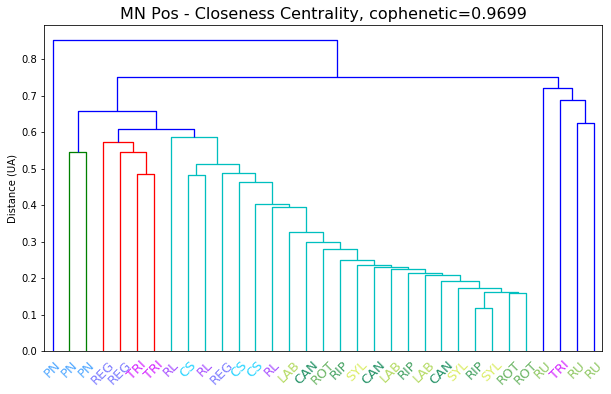

In [104]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
closeness_pos_MN_df_dist = dist.pdist(closeness_pos_MN.T, metric='euclidean')
Z_closeness_pos_MN = hier.linkage(closeness_pos_MN_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_closeness_pos_MN, closeness_pos_MN_df_dist)[0]

# Plot the dendrogram
title = f'MN Pos - Closeness Centrality, cophenetic={coph:.4f}'
plot_dendogram(Z_closeness_pos_MN, title)

MDB Influence Dendrogram

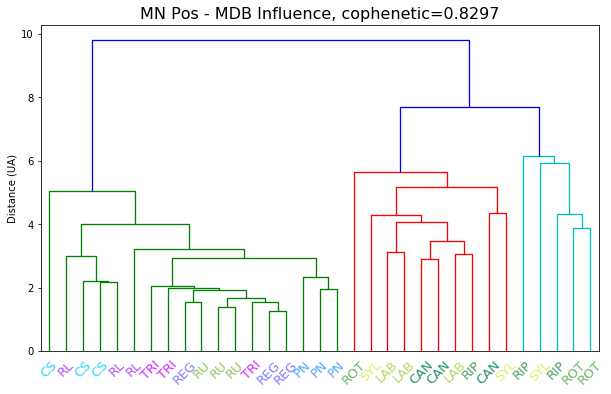

In [105]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
MDBs_pos_MN_df_dist = dist.pdist(MDBs_pos_MN.T, metric='euclidean')
Z_MDBs_pos_MN = hier.linkage(MDBs_pos_MN_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_MDBs_pos_MN, MDBs_pos_MN_df_dist)[0]

# Plot the dendrogram
title = f'MN Pos - MDB Influence, cophenetic={coph:.4f}'
plot_dendogram(Z_MDBs_pos_MN, title)

GCD-11 Dendrogram

In [106]:
# Calculating the distance matrix (between the samples) of the secondary dataset
corrMat_pos_MN_df_dist = dist.pdist(corrMat_pos_MN.T)

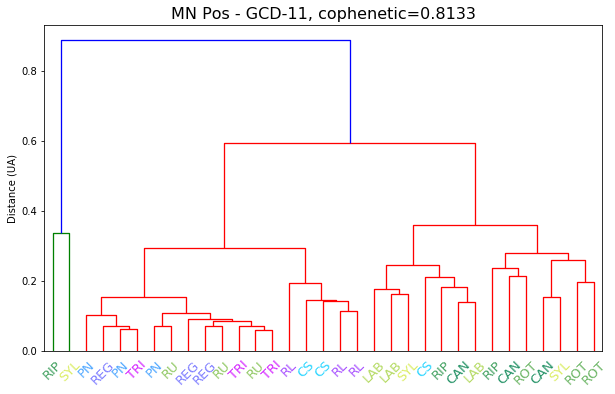

In [107]:
# Build the linkage matrix of the HCA
Z_GCD_pos_MN = hier.linkage(corrMat_pos_MN_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_GCD_pos_MN, corrMat_pos_MN_df_dist)[0]

# Plot the dendrogram
title = f'MN Pos - GCD-11, cophenetic={coph:.4f}'
plot_dendogram(Z_GCD_pos_MN, title)

### Comparing HCA Discrimination - Info for Part of Fig. 3.9

Using 3 different metrics explained in the dissertation:

- Discrimination Distance
- Correct Clustering Percentage
- Correct First Cluster

Functions applied here (`dist_discrim` and `correct_1stcluster_fraction`) from multianalysis.py file of this repository with explanations of each step to calculate the different metrics.

Correct (Group) Clustering definition - samples of a group all clustered together before any other sample clustered with a sample of said group.

In [108]:
# Linkage Matrices of the different dendrograms built from the secondary datasets
Z = (Z_degree_neg_TF, Z_betw_neg_TF, Z_closeness_neg_TF, Z_MDBs_neg_TF, Z_GCD_neg_TF,
     Z_degree_pos_TF, Z_betw_pos_TF, Z_closeness_pos_TF, Z_MDBs_pos_TF, Z_GCD_pos_TF,
    Z_degree_neg_MN, Z_betw_neg_MN, Z_closeness_neg_MN, Z_MDBs_neg_MN, Z_GCD_neg_MN,
    Z_degree_pos_MN, Z_betw_pos_MN, Z_closeness_pos_MN, Z_MDBs_pos_MN, Z_GCD_pos_MN)

# Condensed distance matrices between samples for each of the secondary datasets
dists = (degree_neg_TF_df_dist, betw_neg_TF_df_dist, closeness_neg_TF_df_dist, MDBs_neg_TF_df_dist, corrMat_neg_TF_df_dist,
         degree_pos_TF_df_dist, betw_pos_TF_df_dist, closeness_pos_TF_df_dist, MDBs_pos_TF_df_dist, corrMat_pos_TF_df_dist,
        degree_neg_MN_df_dist, betw_neg_MN_df_dist, closeness_neg_MN_df_dist, MDBs_neg_MN_df_dist, corrMat_neg_MN_df_dist,
        degree_pos_MN_df_dist, betw_pos_MN_df_dist, closeness_pos_MN_df_dist, MDBs_pos_MN_df_dist, corrMat_pos_MN_df_dist)

# Names for each of the secondary datasets - Nomenclature: Analysis Method_ESIMode_Identification of original dataset (TF or MN)
colnames = ['Degree_neg_TF', 'Betweenness_neg_TF', ' Closeness_neg_TF', 'MDB Influence_neg_TF', 'GCD-11_neg_TF',
            'Degree_pos_TF', 'Betweenness_pos_TF', ' Closeness_pos_TF', 'MDB Influence_pos_TF', 'GCD-11_pos_TF',
           'Degree_neg_MN', 'Betweenness_neg_MN', ' Closeness_neg_MN', 'MDB Influence_neg_MN',  'GCD-11_neg_MN',
           'Degree_pos_MN', 'Betweenness_pos_MN', ' Closeness_pos_MN', 'MDB Influence_pos_MN',  'GCD-11_pos_MN']

In [109]:
disc_average = np.zeros((1,20)) # Discrimination Distance
disc_correct = np.zeros((1,20)) # Correct Clustering Percentage
disc_1stclust = np.zeros((1,20)) # Correct First Cluster Percentage

for i in range(len(Z)):
    data = degree_neg_TF
    
    # Discrimination Distance and Correct Clustering Percentage
    discrim = ma.dist_discrim(data, Z[i], method = 'average')  # all samples have the same order
    disc_average[0,i] = discrim[0]
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])
    
    # Correct First Cluster Percentage
    disc_1stclust[0,i] = ma.good_first_cluster_fraction(data, Z[i]) # all samples have the same order
    
# Transforming results into DataFrames    
disc_average = pd.DataFrame(disc_average, index = ['Discrimination Distance'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct * 100 / 11, index = ['% correct groupings'], columns = colnames) # Transforming into %s
disc_1stclust = pd.DataFrame(disc_1stclust * 100, index = ['% correct 1st cluster'], columns = colnames) # Transforming into %s

# Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:10], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['Discrimination Distance']).T, disc_average.iloc[:,10:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:10], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['% correct groupings']).T, disc_correct.iloc[:,10:]], axis = 1)
disc_1stclust = pd.concat([disc_1stclust.iloc[:,:10], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['% correct 1st cluster']).T, disc_1stclust.iloc[:,10:]], axis = 1)

#### Representation of the results from the three metrics with heatmaps

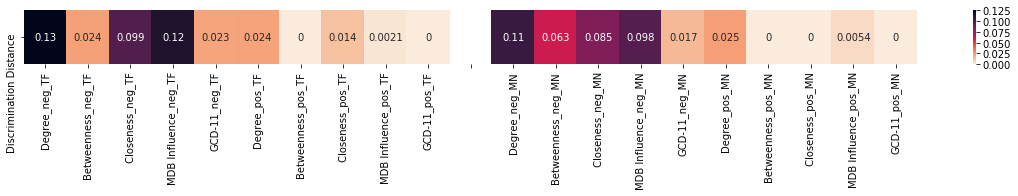

In [110]:
# Discrimination Distance
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.show()

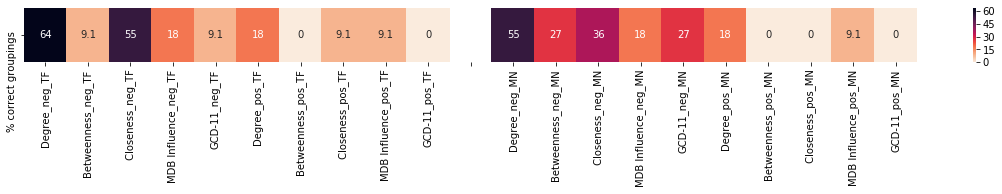

In [111]:
# Correct Clustering percentage
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

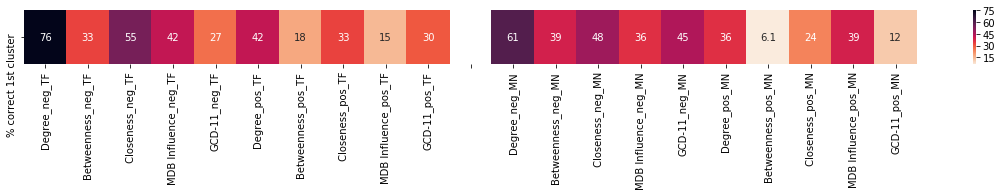

In [112]:
# Correct First Cluster percentage
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_1stclust, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### K-means Clustering Analysis

K-means clustering analysis was applied by using the appropriate functions of the scikit-learn as done in the following cells.

In [113]:
import sklearn.cluster as skclust

#### Example of what happens in a K-means clustering analysis and how samples are separated 

Use of the sci-kit learn Python package - sklearn. 

Cluster number equal to the amount of groups. Default parameters except number of clusters.

K-means clustering analysis has an intrinsically random side to it depending on the starting position of the clusters and existence of local minima.

In [114]:
# Setting the K-means Clustering
Kmean = skclust.KMeans(n_clusters=11)

In [115]:
# Fitting the K-means clustering analysis to a dataset
a = Kmean.fit(degree_neg_TF.T)
a.inertia_ # Results of the function to be minimized by the K-means algorithm_
# sum of squared distances of the samples to the cluster centers

1514.6

In [116]:
# Example of the cluster mades with the K-means clustering analysis. Samples identified by their groups
dicto = {}

for i, lbl in enumerate(a.labels_):
    dicto.setdefault(lbl, []).append(all_labels[i])
dicto

{7: ['CAN', 'CAN', 'SYL', 'TRI'],
 1: ['CAN', 'LAB', 'LAB', 'LAB', 'SYL'],
 2: ['CS', 'CS', 'CS', 'RL', 'RL', 'RL'],
 5: ['PN', 'PN', 'PN'],
 0: ['REG'],
 3: ['REG', 'REG'],
 4: ['RIP', 'RIP', 'RIP', 'SYL'],
 6: ['ROT', 'ROT', 'ROT'],
 8: ['RU', 'RU', 'RU'],
 10: ['TRI'],
 9: ['TRI']}

### K-means clustering applied to all networks

Using 3 different metrics explained in the dissertation:

- Discrimination Distance (for K-means clustering)
- Correct Clustering Percentage (for K-means clustering)
- Adjusted Rand Index (calculated by scikit-learn - `adjusted_rand_index`)

Due to the randomness of the K-means clustering analysis (position of initial cluster centers leading to different local minima), this analysis was iterated 150 times and the 10% of analysis that led to a greater minimization of the objective function - sum of squared distances of the samples to the cluster centers - were chosen to calculate the 3 different metrics mentioned. The Median of the different metrics were taken as the final results.

`Kmeans_discrim` function applied here from multianalysis.py file of this repository with explanations of each step to calculate the different metrics.

Correct clustering definition - K-means Cluster contains all and only the samples of a single group.

In [117]:
# Datasets to apply the K-means Clustering Analysis
Data = (degree_neg_TF, betw_neg_TF, closeness_neg_TF, MDBs_neg_TF, corrMat_neg_TF,
        degree_pos_TF, betw_pos_TF, closeness_pos_TF, MDBs_pos_TF, corrMat_pos_TF,
       degree_neg_MN, betw_neg_MN, closeness_neg_MN, MDBs_neg_MN, corrMat_neg_MN,
       degree_pos_MN, betw_pos_MN, closeness_pos_MN, MDBs_pos_MN, corrMat_pos_MN)

In [118]:
disc_average = np.zeros((1,20)) # Discrimination Distance
#disc_median = np.zeros((1,20))
disc_correct = np.zeros((1,20)) # Correct Clustering Percentage
disc_rand = np.zeros((1,20)) # Adjusted Rand Index

for i in range(len(Data)):
    # Applying Kmeans_discrim function 150 times, taking the best 10% and measuring the Discrimination Distance, Correct
    # Clustering percentage and adjusted Rand Index metrics to evaluate the discrimination.
    discrim = ma.Kmeans_discrim(Data[i], method = 'average', iter_num=150, best_fraction=0.1)
    
    # Lists for the results of the best k-means clustering
    average = []
    correct = []
    rand = []
    for j in discrim:
        average.append(discrim[j][0]) # Discrimination Distance
        all_correct = np.array(list(discrim[j][1].values()))
        correct.append(len(all_correct[all_correct>0])) # Correct Clustering Percentages
        rand.append(discrim[j][2]) # Adjusted Rand Index
    
    # Putting results into the arrays - median of the best k-means clustering
    disc_average[0,i] = np.median(average) 
    disc_correct[0,i] = np.median(correct)
    disc_rand[0,i] = np.median(rand)

# Transforming into DataFrame
disc_average = pd.DataFrame(disc_average, index = ['Discrimination Distance'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct / 11 * 100, index = ['% correct groupings'], columns = colnames) # Transforming into %s
disc_rand = pd.DataFrame(disc_rand, index = ['Rand Index'], columns = colnames)

# Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:10], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['Discrimination Distance']).T, disc_average.iloc[:,10:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:10], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['% correct groupings']).T, disc_correct.iloc[:,10:]], axis = 1)
disc_rand = pd.concat([disc_rand.iloc[:,:10], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['Rand Index']).T, disc_rand.iloc[:,10:]], axis = 1)

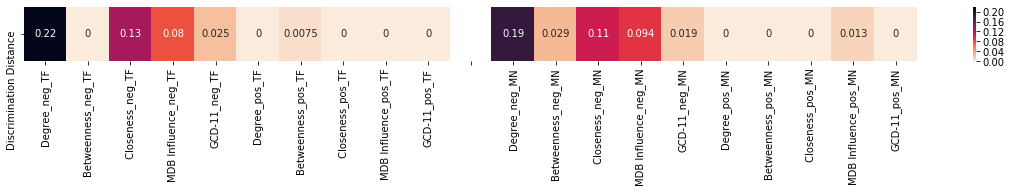

In [119]:
# Discrimination Distance
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.show()

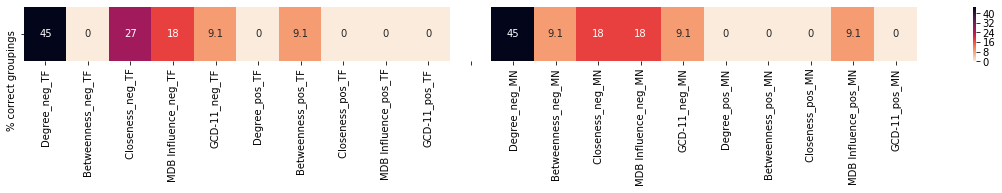

In [120]:
# Correct Clustering Percentage
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

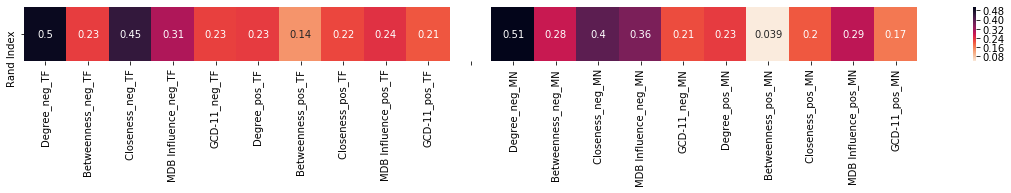

In [121]:
# Adjusted Rand Index
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_rand, annot=True, ax=ax, cmap = sns.cm.rocket_r)

## Supervised Statistical Analysis

For the rest of the notebook, only the 'TF' secondary datasets will be analysed as to mimic the images in the dissertation.

The results starting with either the 'TF' or 'MN' networks are similar, leading to the same conclusions.

The datasets that will be analyzed:

In [122]:
# Negative Grapevine Dataset secondary datasets identified just by the network analysis method 
# Positive Grapevine Dataset secondary datasets identified by the network analysis method and by 'pos' (positive)
datasets = {'Degree': degree_neg_TF, 'Betweenness': betw_neg_TF, 'Closeness' : closeness_neg_TF, 
            'MDB Inf.': MDBs_neg_TF, 'GCD-11': corrMat_neg_TF,
            'TF_pos_degree': degree_pos_TF, 'TF_pos_betweenness': betw_pos_TF, 'TF_pos_closeness' : closeness_pos_TF, 
            'TF_pos_MDBs': MDBs_pos_TF, 'TF_pos_GCD-11': corrMat_pos_TF}#,
            #'MN_neg_degree': degree_neg_MN, 'MN_neg_betweenness': betw_neg_MN, 'MN_neg_closeness' : closeness_neg_MN, 
            #'MN_neg_MDBs': MDBs_neg_MN, 'MN_neg_GCD-11': corrMat_neg_MN,
            #'MN_pos_degree': degree_pos_MN, 'MN_pos_betweenness': betw_pos_MN, 'MN_pos_closeness' : closeness_pos_MN, 
            #'MN_pos_MDBs': MDBs_pos_MN, 'MN_pos_GCD-11': corrMat_pos_MN}

## Random Forests

### Test number of trees needed for predictive accuracy convergence for the different secondary datasets

Random Forest models with different number of trees will be built to assess when the predictive accuracy of the different models stops increasing with higher number of trees.

In [123]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
#Vector with values for the parameter n_estimators
values = {'n_estimators': range(10,400,2)} # Models will be built from 10 to 400 trees in 2 tree intervals.

rf = skensemble.RandomForestClassifier(n_estimators = 200)
clf = GridSearchCV(rf, values, cv = 3)

In [124]:
param = []
test_score = []

# For each dataset,building the Random Forest models with the different number of trees
# and storing the predictive accuracy (estimated by 3-fold cross-validation)
for name, dataset in datasets.items():
    print('Fitting', name, '...', end=' ')
    clf.fit(dataset.T, all_labels)
    param.append(clf.cv_results_['param_n_estimators'])
    test_score.append(clf.cv_results_['mean_test_score'])
    print('Done!')

Fitting Degree ... Done!
Fitting Betweenness ... Done!
Fitting Closeness ... Done!
Fitting MDB Inf. ... Done!
Fitting GCD-11 ... Done!
Fitting TF_pos_degree ... Done!
Fitting TF_pos_betweenness ... Done!
Fitting TF_pos_closeness ... Done!
Fitting TF_pos_MDBs ... Done!
Fitting TF_pos_GCD-11 ... Done!


#### Part of Suppl. Fig. 6.10

Text(0.5, 1.0, 'Negative Grapevine Dataset')

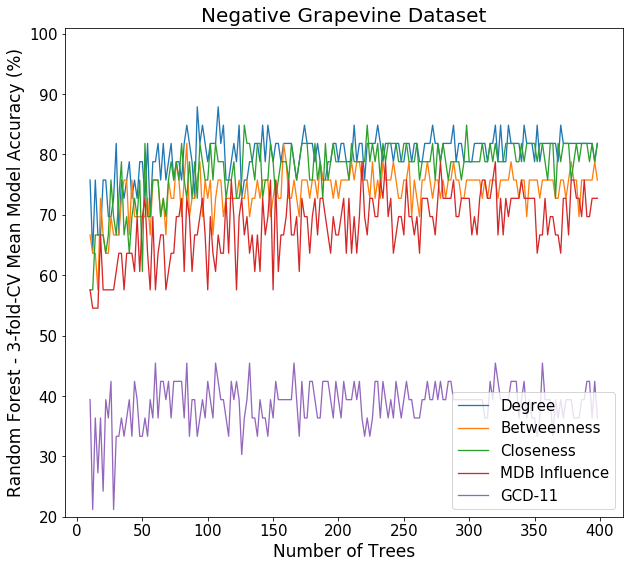

In [125]:
# Plotting the results of the Negative Grapevine Dataset and adjusting parameters of the plot
f, ax = plt.subplots(figsize=(10,9))
for i in range(5):
    plt.plot(param[i], test_score[i]*100)
plt.ylabel('Random Forest - 3-fold-CV Mean Model Accuracy (%)', fontsize = 17)
plt.xlabel('Number of Trees', fontsize = 17)
ax.legend(('Degree', 'Betweenness', 'Closeness', 'MDB Influence', 'GCD-11'), fontsize=15, loc='lower right')
plt.ylim(20,101)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.title('Negative Grapevine Dataset', fontsize=20)

Text(0.5, 1.0, 'Positive Grapevine Dataset')

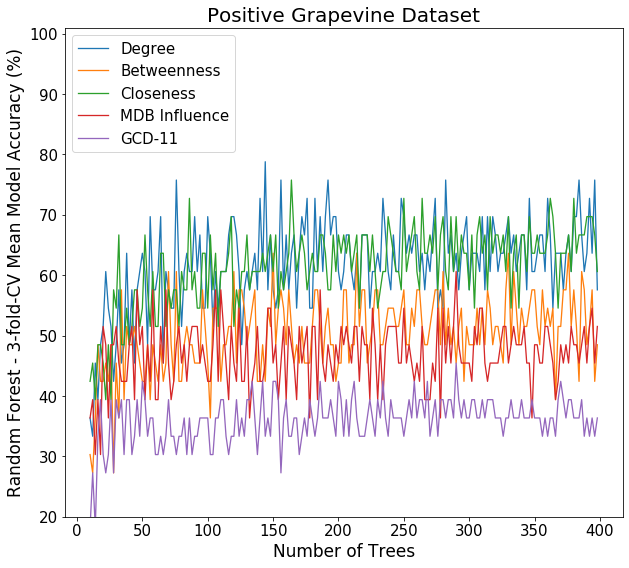

In [126]:
# Plotting the results of the Positive Grapevine Dataset and adjusting parameters of the plot
f, ax = plt.subplots(figsize=(10,9))
for i in range(5,10):
    plt.plot(param[i], test_score[i]*100)
plt.ylabel('Random Forest - 3-fold-CV Mean Model Accuracy (%)', fontsize = 17)
plt.xlabel('Number of Trees', fontsize = 17)
ax.legend(('Degree', 'Betweenness', 'Closeness', 'MDB Influence', 'GCD-11'), fontsize=15, loc='upper left')
plt.ylim(20,101)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.title('Positive Grapevine Dataset', fontsize=20)

### Random Forest Application

Stores predictive accuracy of the models, standard deviation of the predictive accuracy (across th iterations) and an ordered list of the most to least important features in building the model according to the Gini Importance calculated by scikit-learn (all estimated by straitified 3-fold cross-validation) of each of the 200 iterations (with different samplings of the 3 folds) of models built for each secondary dataset.

Use of the `simple_RF` function of multianalysis.py (uses Random Forest algorithm from scikit-learn) where each step of the process is better explained.


In [127]:
# Preparations of dicts:
Scores = {} # Stores Predictive Accuracy
Scores_std = {} # Stores Predictive Accuracy's Standard Deviation
Imp_feat = {} # Stores ordered list of most to least important feature to build the model


for name, data in datasets.items():
    print(f'Fitting random forest for {name} ...', end='')
    rf, imp_features = ma.simple_RF(data, iter_num=200)

    Scores[name] = rf
    Scores_std[name] = np.std(rf)
    Imp_feat[name] = imp_features
    print(f'done')    

Fitting random forest for Degree ...done
Fitting random forest for Betweenness ...done
Fitting random forest for Closeness ...done
Fitting random forest for MDB Inf. ...done
Fitting random forest for GCD-11 ...done
Fitting random forest for TF_pos_degree ...done
Fitting random forest for TF_pos_betweenness ...done
Fitting random forest for TF_pos_closeness ...done
Fitting random forest for TF_pos_MDBs ...done
Fitting random forest for TF_pos_GCD-11 ...done


#### Performance of each predictive model - Part of Fig. 3.10

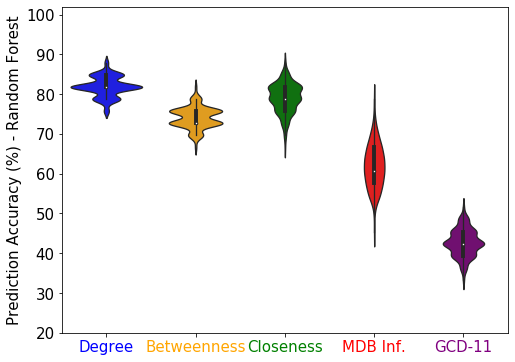

In [128]:
### Negative Grapevine Dataset
# Violin plot of the distribution of the predictive accuracy (in %) across 200 iterations of randomly sampled folds for each 
# secondary dataset and adjustments to the parameters of the plot.
f, ax = plt.subplots(figsize=(8,6))
data = pd.DataFrame.from_dict(Scores).iloc[:,:5] * 100
data.columns = ['Degree', 'Betweenness', 'Closeness', 'MDB Inf.', 'GCD-11']
colors = ['blue','orange','green','red','purple']
sns.violinplot( data = data, palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy (%) - Random Forest', fontsize = 15)
plt.ylim([20,102])
ax.tick_params(axis='x', which='major', labelsize = 15)
ax.tick_params(axis='y', which='major', labelsize = 15)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)
#plt.savefig('Net-RF-NGD')

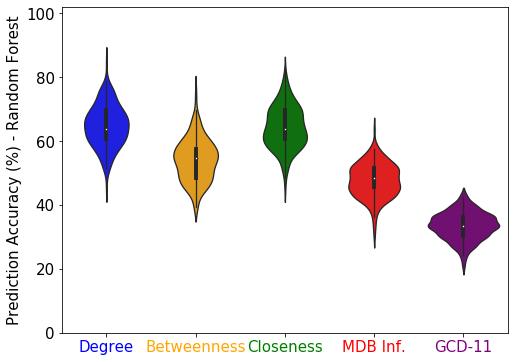

In [129]:
### Positive Grapevine Dataset
# Violin plot of the distribution of the predictive accuracy (in %) across 200 iterations of randomly sampled folds for each 
# secondary dataset and adjustments to the parameters of the plot.
f, ax = plt.subplots(figsize=(8,6))
data = pd.DataFrame.from_dict(Scores).iloc[:,5:] * 100
data.columns = ['Degree', 'Betweenness', 'Closeness', 'MDB Inf.', 'GCD-11']
colors = ['blue','orange','green','red','purple']
sns.violinplot( data = data, palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy (%) - Random Forest', fontsize = 15)
plt.ylim([0,102])
ax.tick_params(axis='x', which='major', labelsize = 15)
ax.tick_params(axis='y', which='major', labelsize = 15)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)
#plt.savefig('Net-RF-PGD')

#### Info for part of Fig. 3.10

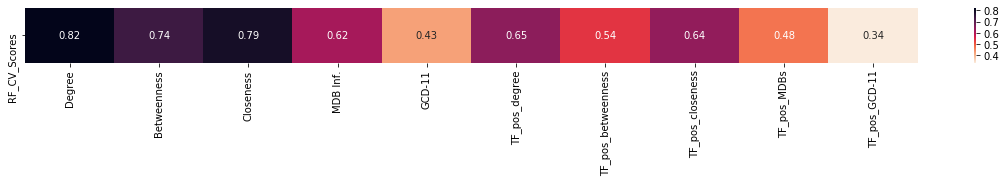

In [130]:
Scores_A = {}
for i in Scores:
    Scores_A[i] = np.mean(Scores[i])

Scores_H = pd.DataFrame(list(Scores_A.values()), index = Scores_A.keys()).T
Scores_std_H = pd.DataFrame(list(Scores_std.values()), index = Scores_std.keys()).T

f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Scores_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_Scores'])

In [131]:
Scores_A

{'Degree': 0.8190909090909091,
 'Betweenness': 0.7412121212121212,
 'Closeness': 0.7910606060606059,
 'MDB Inf.': 0.6195454545454545,
 'GCD-11': 0.4266666666666666,
 'TF_pos_degree': 0.6478787878787879,
 'TF_pos_betweenness': 0.5409090909090909,
 'TF_pos_closeness': 0.6427272727272728,
 'TF_pos_MDBs': 0.47666666666666657,
 'TF_pos_GCD-11': 0.335}

#### Important Features to build Random Forest models from MDB Influence secondary datasets - Part of Table 3.6

In [132]:
# Negative Grapevine Dataset

# Important MDBs to build the discriminatory Random Forest models
Imp_feat['MDB Inf.']
important_feat_neg_RF = pd.DataFrame(columns=['Place', 'MDB', 'Gini Importance'])
important_feat_neg_RF = important_feat_neg_RF.set_index('Place')
n=1
for i,j,m in Imp_feat['MDB Inf.']:
    important_feat_neg_RF.loc[n]= m,j
    n = n+1
important_feat_neg_RF

,MDB,Gini Importance
Place,,
1,O,0.087565
2,H2,0.085977
3,NH3(-O),0.084392
4,CO2,0.081824
5,CH2,0.078550
6,SO3,0.078348
7,CO,0.075649
8,C2H2O,0.072837
9,CONH,0.068559


In [133]:
# Positive Grapevine Dataset

# Important MDBs to build the discriminatory Random Forest models
Imp_feat['TF_pos_MDBs']
important_feat_pos_RF = pd.DataFrame(columns=['Place', 'MDB', 'Gini Importance'])
important_feat_pos_RF = important_feat_pos_RF.set_index('Place')
n=1
for i,j,m in Imp_feat['TF_pos_MDBs']:
    important_feat_pos_RF.loc[n]= m,j
    n = n+1
important_feat_pos_RF

,MDB,Gini Importance
Place,,
1,O,0.085189
2,CONH,0.081743
3,NH3(-O),0.076721
4,CH2,0.074732
5,H2O,0.071796
6,CO,0.069640
7,NCH,0.068564
8,CO2,0.068485
9,O(-NH),0.067601


## PLS-DA - Classifiers

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong) with one-hot encoding.

In [134]:
matrix = pd.get_dummies(all_labels)
matrix

,CAN,CS,LAB,PN,REG,RIP,RL,ROT,RU,SYL,TRI
0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,0
6,0,0,1,0,0,0,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,0,0
8,0,0,1,0,0,0,0,0,0,0,0
9,0,0,0,1,0,0,0,0,0,0,0


### Optimization - Search for the best number of components to use - Part of Suppl. Fig 6.11

PLS-DA models were built using the PLSRegression module of scikit-learn while imposing a decision rule where the group corresponding to the maximum value in the predcited regression vector (one value for each group) obtained for a test sample (ypred). 

The number of components were optimized by observing the score metric of the PLSRegression of scikit learn, that is, the 1 - PRESS/SS or Q2 of models built with 1 to n components.

PRESS - Predictive Residual Sum of Squares
SS - residual Sum of Squares

To observe details of the `optim_PLS` function used to build the models and extract results, see multianalysis.py file. 

These regression metrics are not suitable to evaluate the performance of the classifier, they were just used to optimize the number of components to build the final PLS-DA models.

In [135]:
%%capture --no-stdout
PLS_optim = {}
# Build and extract metrics from models build with different number of components by using the optim_PLS function.
for name, data in datasets.items():
    print(f'Optimizing PLS-DA for {name} ...', end='')
    if name.endswith('egree') or name.endswith('loseness'): # For degree, closeness secondary datasets - maximum 30 components
        CVs, CVr2s, MSEs = ma.optim_PLS(data, max_comp = 30)
    else: # For betweenness, MDB Influence and GCD-11 secondary datasets - maximum 10 components
        CVs, CVr2s, MSEs = ma.optim_PLS(data, max_comp = 10)
    PLS_optim[name] = CVs
    print(f'done')    

Optimizing PLS-DA for Degree ...done
Optimizing PLS-DA for Betweenness ...done
Optimizing PLS-DA for Closeness ...done
Optimizing PLS-DA for MDB Inf. ...done
Optimizing PLS-DA for GCD-11 ...done
Optimizing PLS-DA for TF_pos_degree ...done
Optimizing PLS-DA for TF_pos_betweenness ...done
Optimizing PLS-DA for TF_pos_closeness ...done
Optimizing PLS-DA for TF_pos_MDBs ...done
Optimizing PLS-DA for TF_pos_GCD-11 ...done


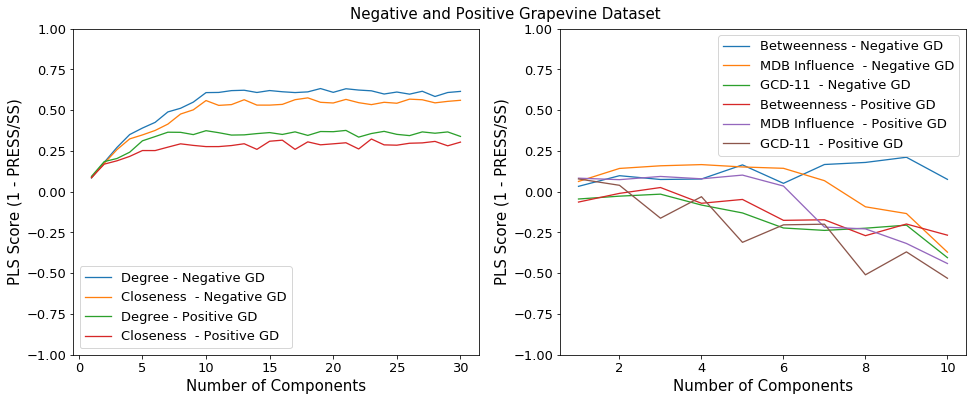

In [136]:
# Plotting the results and adjusting plot parameters
f, axes = plt.subplots(1, 2, figsize = (16,6))
quadrant = [axes[0], axes[1]]
plt.suptitle('Negative and Positive Grapevine Dataset', fontsize = 15, x = 0.5, y = 0.93)

for name, data in PLS_optim.items():
    # 1 to 30 components
    if data[-1] > 0.2:
        quadrant[0].plot(range(1,31),data)
        quadrant[0].set_xlabel('Number of Components', fontsize=15)
        quadrant[0].set_ylabel('PLS Score (1 - PRESS/SS)', fontsize=15)
        quadrant[0].tick_params(axis='both', which='major', labelsize=13)
        quadrant[0].legend(('Degree - Negative GD', 'Closeness  - Negative GD', 'Degree - Positive GD', 'Closeness  - Positive GD'), fontsize=13)
        quadrant[0].set_ylim([-1, 1])
    # 1 to 10 components
    else:
        quadrant[1].plot(range(1,11),data)
        quadrant[1].set_xlabel('Number of Components', fontsize=15)
        quadrant[1].set_ylabel('PLS Score (1 - PRESS/SS)', fontsize=15)
        quadrant[1].tick_params(axis='both', which='major', labelsize=13)
        quadrant[1].legend(('Betweenness - Negative GD', 'MDB Influence  - Negative GD', 'GCD-11  - Negative GD',
                            'Betweenness - Positive GD', 'MDB Influence  - Positive GD', 'GCD-11  - Positive GD'), fontsize=13)
        quadrant[1].set_ylim([-1, 1])

For the Degree and Closeness secondary datasets, PLS-DA models were built with 11 components.

For the Betweenness, MDB Influence and GCD-11 secondary datasets, PLS-DA models were built with 5 components.

### Application of PLS-DA - Part of Fig. 3.10

Use of function `model_PLSDA` of multianalysis.py file. See this file to see the application of this function more in-depth (used `PLSRegression` from scikit-learn).

3 different feature importance metrics (feat_type):

- VIP (Variable Importance/Influence in Projection) - used in dissertation (slowest)
- Coef. (regression coefficients - sum)
- Weights (Sum of the X-weights for each feature)

In [137]:
# Dictionaries to store results
PLS_accu = {}
PLS_score = {}
PLS_feat = {}

In [138]:
%%capture --no-stdout

# For each secondary dataset, fit PLS-DA models on 200 randomly sampled folds (for stratified 3-fold cross validation.
# Store results in dictionaries (results for 200 iterations).
for name, data in datasets.items():
    print(f'Fitting PLS-DA for {name} ...', end='')
    if name.endswith('egree') or name.endswith('loseness'):
        accu, score, u, imp_features = ma.model_PLSDA(data, n_comp = 11, iter_num = 200, feat_type = 'VIP')
    else:
        accu, score, u, imp_features = ma.model_PLSDA(data, n_comp = 5, iter_num = 200, feat_type = 'VIP')
    PLS_accu[name] = accu
    PLS_score[name] = score
    PLS_feat[name] = imp_features
    print(f'done') 

Fitting PLS-DA for Degree ...done
Fitting PLS-DA for Betweenness ...done
Fitting PLS-DA for Closeness ...done
Fitting PLS-DA for MDB Inf. ...done
Fitting PLS-DA for GCD-11 ...done
Fitting PLS-DA for TF_pos_degree ...done
Fitting PLS-DA for TF_pos_betweenness ...done
Fitting PLS-DA for TF_pos_closeness ...done
Fitting PLS-DA for TF_pos_MDBs ...done
Fitting PLS-DA for TF_pos_GCD-11 ...done


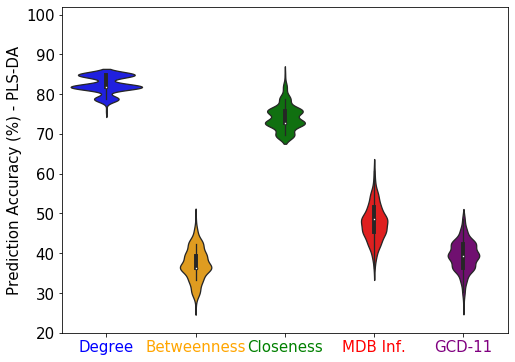

In [139]:
### Negative Grapevine Dataset
# Plot the distribution of prediction accuracy of the 200 iterations of models built from each of the secondary datasets
# Part of Fig. 3.10
f, ax = plt.subplots(figsize=(8,6))
data = pd.DataFrame.from_dict(PLS_accu).iloc[:,:5] * 100
data.columns = ['Degree', 'Betweenness', 'Closeness', 'MDB Inf.', 'GCD-11']
colors = ['blue','orange','green','red', 'purple']
sns.violinplot( data = data, palette = colors, alpha = 0.5)
plt.ylabel('Prediction Accuracy (%) - PLS-DA', fontsize = 15)
plt.ylim([20,102])
ax.tick_params(axis='x', which='major', labelsize = 15)
ax.tick_params(axis='y', which='major', labelsize = 15)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)
    
#plt.savefig('Net-PLSDA-NGD')

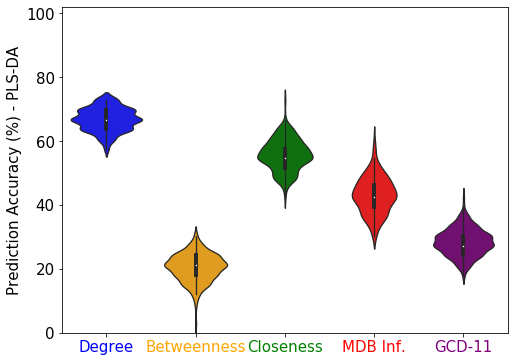

In [140]:
### Positive Grapevine Dataset
# Plot the distribution of prediction accuracy of the 200 iterations of models built from each of the secondary datasets
# Part of Fig. 3.10
f, ax = plt.subplots(figsize=(8,6))
data = pd.DataFrame.from_dict(PLS_accu).iloc[:,5:] * 100
data.columns = ['Degree', 'Betweenness', 'Closeness', 'MDB Inf.', 'GCD-11']
colors = ['blue','orange','green','red', 'purple']
sns.violinplot( data = data, palette = colors, alpha = 0.5)
plt.ylabel('Prediction Accuracy (%) - PLS-DA', fontsize = 15)
plt.ylim([0,102])
ax.tick_params(axis='x', which='major', labelsize = 15)
ax.tick_params(axis='y', which='major', labelsize = 15)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)
    
#plt.savefig('Net-PLSDA-PGD')

In [141]:
# Average prediction accuracy of the models built for each of the secondary datasets
# estimated by stratified 3-fold cross validation
Accuracy = {}
Score = {}
Accuracy_std = {}
Score_std = {}
for name in PLS_score.keys():
    Accuracy[name] = np.mean(PLS_accu[name])
    Score[name] = np.mean(PLS_score[name])
    
    Accuracy_std[name] = np.std(PLS_accu[name])
    Score_std[name] = np.std(PLS_score[name])

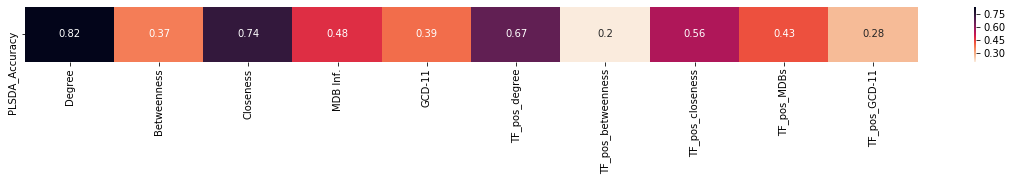

In [142]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T

f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])
plt.show()

In [143]:
Accuracy_H

,Degree,Betweenness,Closeness,MDB Inf.,GCD-11,TF_pos_degree,TF_pos_betweenness,TF_pos_closeness,TF_pos_MDBs,TF_pos_GCD-11
0,0.824242,0.373333,0.741818,0.476061,0.394394,0.667424,0.205,0.557273,0.431364,0.284394


#### Important Features to build PLS-DA models from MDB Influence secondary datasets

In [144]:
# Important MDBs to build the PLS-DA Models
PLS_feat['MDB Inf.']
important_feat_neg_PLSDA = pd.DataFrame(columns=['Place', 'MDB', 'Gini Importance'])
important_feat_neg_PLSDA = important_feat_neg_PLSDA.set_index('Place')
n=1
for i,j,m in PLS_feat['MDB Inf.']:
    important_feat_neg_PLSDA.loc[n]= m,j
    n = n+1
important_feat_neg_PLSDA

,MDB,Gini Importance
Place,,
1,CH2,1.581197
2,H2,1.498741
3,O,1.477653
4,NCH,1.282329
5,CO,1.253878
6,CHOH,1.162482
7,NH3(-O),1.034830
8,C2H2O,0.804271
9,CO2,0.722630


In [145]:
# Important MDBs to build the PLS-DA Models
PLS_feat['TF_pos_MDBs']
important_feat_pos_PLSDA  = pd.DataFrame(columns=['Place', 'MDB', 'Gini Importance'])
important_feat_pos_PLSDA = important_feat_pos_PLSDA.set_index('Place')
n=1
for i,j,m in PLS_feat['TF_pos_MDBs']:
    important_feat_pos_PLSDA.loc[n]= m,j
    n = n+1
important_feat_pos_PLSDA

,MDB,Gini Importance
Place,,
1,CH2,1.715770
2,H2O,1.531769
3,O,1.385613
4,CO,1.183769
5,H2,1.118565
6,CONH,0.986289
7,CO2,0.968861
8,O(-NH),0.824555
9,NCH,0.813562


## Permutation Tests - Part of Suppl. Fig. 6.12

Permutation tests were made for both the Random Forest and PLS-DA models with 1000 permutations to assess the significance of the predictive accuracy results. 

Initially, permutation tests were made for both the MDiNs made with our transformation list (TF) and MetaNetter's transformation list (MN), however, as was done for the rest of the supervised statistical analyses, only the results for the MDiNs made with our transformation list (TF) are now shown.

### Permutation Tests - Random Forests (very slow)

Use of `permutation_RF` function from multianalysis.py. See details about the application of this function in the multianalysis.py file.

In [146]:
# Store Results
CV = {}
PMs = {}
pvalue = {}

#all_data = (degree_neg_TF, betw_neg_TF, closeness_neg_TF, MDBs_neg_TF, corrMat_neg_TF,
#            degree_pos_TF, betw_pos_TF, closeness_pos_TF, MDBs_pos_TF, corrMat_pos_TF,
#            degree_neg_MN, betw_neg_MN, closeness_neg_MN, MDBs_neg_MN, corrMat_neg_MN,
#            degree_pos_MN, betw_pos_MN, closeness_pos_MN, MDBs_pos_MN, corrMat_pos_MN,)
#names = ('TF_neg_Degree', 'TF_neg_Betweenness', 'TF_neg_Closeness', 'TF_neg_MDBs', 'TF_neg_GCD-11',
#         'TF_pos_Degree', 'TF_pos_Betweenness', 'TF_pos_Closeness', 'TF_pos_MDBs', 'TF_pos_GCD-11',
#         'MN_neg_Degree', 'MN_neg_Betweenness', 'MN_neg_Closeness', 'MN_neg_MDBs', 'MN_neg_GCD-11',
#         'MN_pos_Degree', 'MN_pos_Betweenness', 'MN_pos_Closeness', 'MN_pos_MDBs', 'MN_pos_GCD-11',)

all_data = (degree_neg_TF, betw_neg_TF, closeness_neg_TF, MDBs_neg_TF, corrMat_neg_TF,
            degree_pos_TF, betw_pos_TF, closeness_pos_TF, MDBs_pos_TF, corrMat_pos_TF)
names = ('Degree', 'Betweenness', 'Closeness', 'MDB Inf.', 'GCD-11',
         'pos_Degree', 'pos_Betweenness', 'pos_Closeness', 'pos_MDB Inf.', 'pos_GCD-11')

# Application of permutations tests (with 1000 iterations)
for name, data in zip(names, all_data):
    print(f'Permutation test (Random Forest) for {name} ...')
    permuta = ma.permutation_RF(data, iter_num=1000, n_fold=3)
    CV[name] = permuta[0]
    PMs[name] = permuta[1]
    pvalue[name] = permuta[2]
    print('Done!')

Permutation test (Random Forest) for Degree ...
Done!
Permutation test (Random Forest) for Betweenness ...
Done!
Permutation test (Random Forest) for Closeness ...
Done!
Permutation test (Random Forest) for MDB Inf. ...
Done!
Permutation test (Random Forest) for GCD-11 ...
Done!
Permutation test (Random Forest) for pos_Degree ...
Done!
Permutation test (Random Forest) for pos_Betweenness ...
Done!
Permutation test (Random Forest) for pos_Closeness ...
Done!
Permutation test (Random Forest) for pos_MDB Inf. ...
Done!
Permutation test (Random Forest) for pos_GCD-11 ...
Done!


#### Left - Negative; Right - Positive

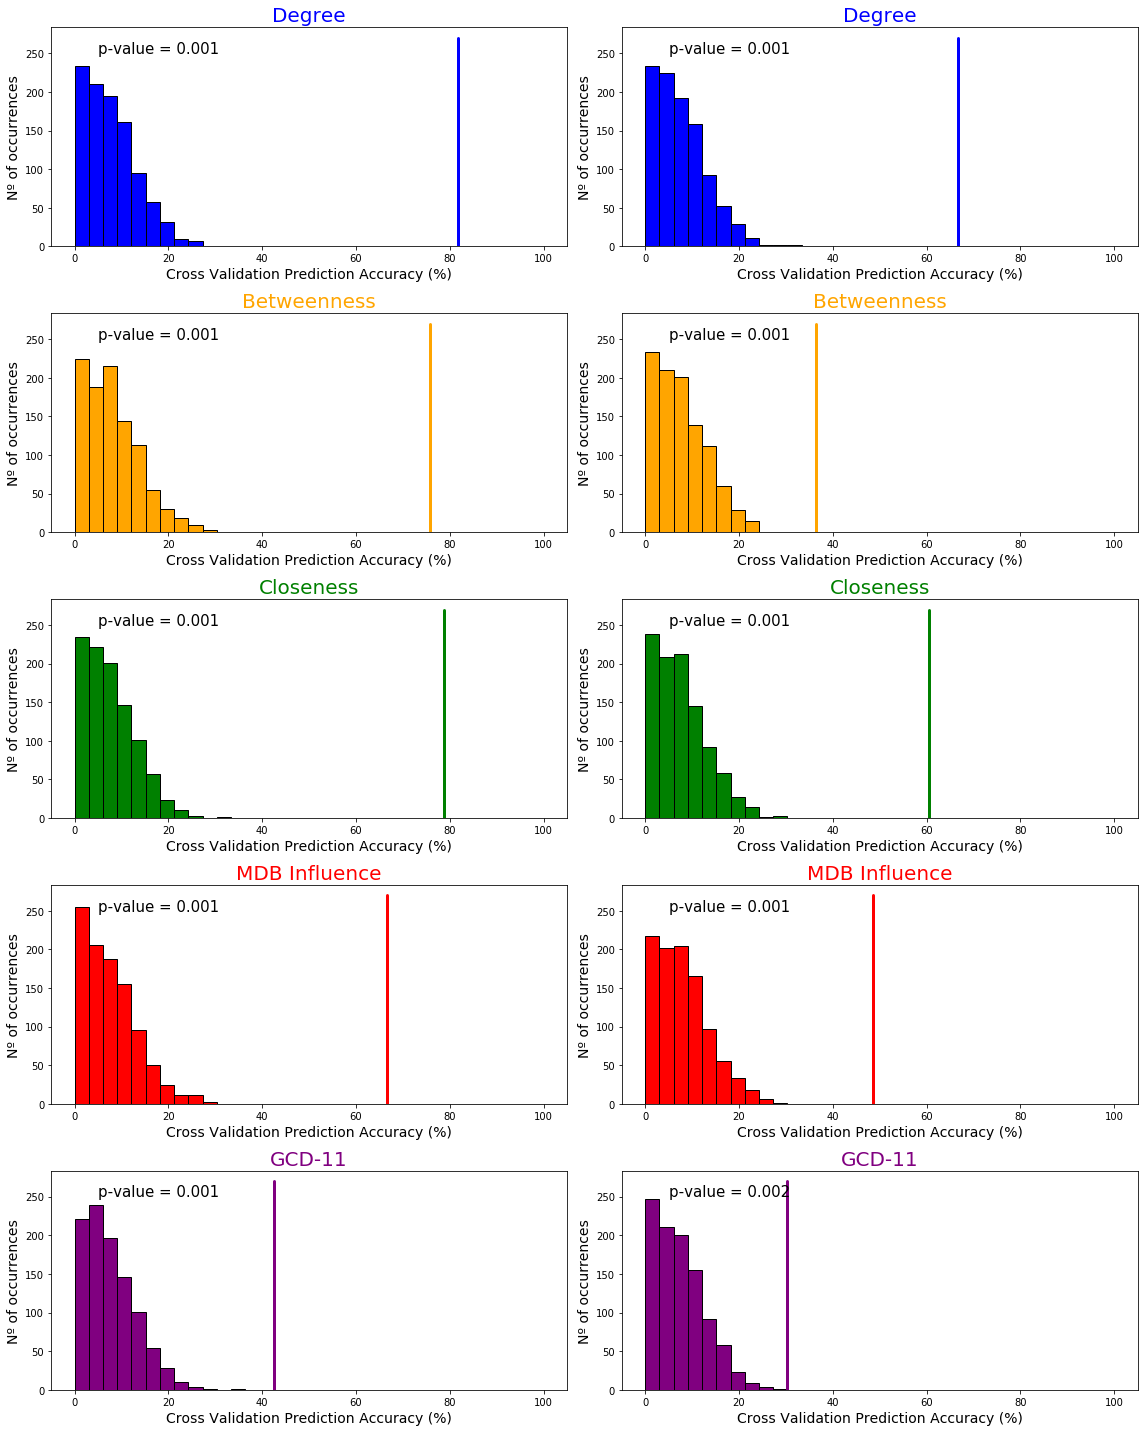

In [149]:
# Plot the Permutations test results - Histogram of predictive accuracies of permutated labels and comparison to reference
# predictive accuracy
f, axes = plt.subplots(5, 2, figsize = (16,20))

# Data to help the plot
Names = ['Degree', 'Betweenness', 'Closeness', 'MDB Inf.', 'GCD-11',
         'pos_Degree', 'pos_Betweenness', 'pos_Closeness', 'pos_MDB Inf.', 'pos_GCD-11']
colors = ['blue', 'orange', 'green', 'red', 'purple'] * 2
quadrant = [axes[0][0], axes[1][0], axes[2][0], axes[3][0], axes[4][0],
           axes[0][1], axes[1][1], axes[2][1], axes[3][1], axes[4][1]]
ylim = [0,270]
n_labels = len(degree_neg_TF.cdl.labels)

# Setting the parameters of the figure
for q, name, color in zip(quadrant, Names, colors):
    q.hist(np.array(PMs[name])*100, n_labels, range=(0, 100.01), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    q.plot(2 * [CV[name]* 100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name], solid_capstyle='round')
    q.set_xlabel('Cross Validation Prediction Accuracy (%)', fontsize=14)
    q.set_ylabel('Nº of occurrences', fontsize=14)
    q.text(5,250, 'p-value = %.3f' % pvalue[name], fontsize = 15)
    if name.startswith('pos'):
        name = name.split('_')[-1]
        if name == 'MDB Inf.':
            name = 'MDB Influence'
#    elif name.endswith('GD'):
#        name = name.split(' ')[0]
    elif name == 'MDB Inf.':
        name = 'MDB Influence'
    q.set_title(name, size = 20, color = color)

plt.tight_layout()
#plt.savefig('Net-Perm-GD-RF')

### Permutation Tests - PLS-DA (slow)

Use of `permutation_PLSDA` function from multianalysis.py. See details about the application of this function in the multianalysis.py file.

In [150]:
# Store Results
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

#all_data = (degree_neg_TF, betw_neg_TF, closeness_neg_TF, MDBs_neg_TF, corrMat_neg_TF,
#            degree_pos_TF, betw_pos_TF, closeness_pos_TF, MDBs_pos_TF, corrMat_pos_TF,
#            degree_neg_MN, betw_neg_MN, closeness_neg_MN, MDBs_neg_MN, corrMat_neg_MN,
#            degree_pos_MN, betw_pos_MN, closeness_pos_MN, MDBs_pos_MN, corrMat_pos_MN,)
#names = ('TF_neg_Degree', 'TF_neg_Betweenness', 'TF_neg_Closeness', 'TF_neg_MDBs', 'TF_neg_GCD-11',
#         'TF_pos_Degree', 'TF_pos_Betweenness', 'TF_pos_Closeness', 'TF_pos_MDBs', 'TF_pos_GCD-11',
#         'MN_neg_Degree', 'MN_neg_Betweenness', 'MN_neg_Closeness', 'MN_neg_MDBs', 'MN_neg_GCD-11',
#         'MN_pos_Degree', 'MN_pos_Betweenness', 'MN_pos_Closeness', 'MN_pos_MDBs', 'MN_pos_GCD-11',)

all_data = (degree_neg_TF, betw_neg_TF, closeness_neg_TF, MDBs_neg_TF, corrMat_neg_TF,
            degree_pos_TF, betw_pos_TF, closeness_pos_TF, MDBs_pos_TF, corrMat_pos_TF)
names = ('Degree - Negative GD', 'Betweenness', 'Closeness', 'MDB Inf.', 'GCD-11',
         'pos_Degree', 'pos_Betweenness', 'pos_Closeness', 'pos_MDB Inf.', 'pos_GCD-11')

# Application of permutations tests (with 1000 iterations) - 11 components for degree or closeness secondary datasets,
# 5 for the rest.
for name, data in zip(names, all_data):
    print(f'permutation test (PLS-DA) for {name} ...')
    if name.endswith('degree') or name.endswith('closeness'):
        permuta = ma.permutation_PLSDA(data, n_comp=11, iter_num=1000)
    else:
        permuta = ma.permutation_PLSDA(data, n_comp=5, iter_num=1000)
    CV_PLS[name] = permuta[0]
    PMs_PLS[name] = permuta[1]
    pvalue_PLS[name] = permuta[2]
    print('Done!')

permutation test (PLS-DA) for Degree - Negative GD ...


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for Betweenness ...


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for Closeness ...
Done!
permutation test (PLS-DA) for MDB Inf. ...
Done!
permutation test (PLS-DA) for GCD-11 ...
Done!
permutation test (PLS-DA) for pos_Degree ...


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for pos_Betweenness ...
Done!
permutation test (PLS-DA) for pos_Closeness ...
Done!
permutation test (PLS-DA) for pos_MDB Inf. ...
Done!
permutation test (PLS-DA) for pos_GCD-11 ...
Done!


#### Left - Negative; Right - Positive

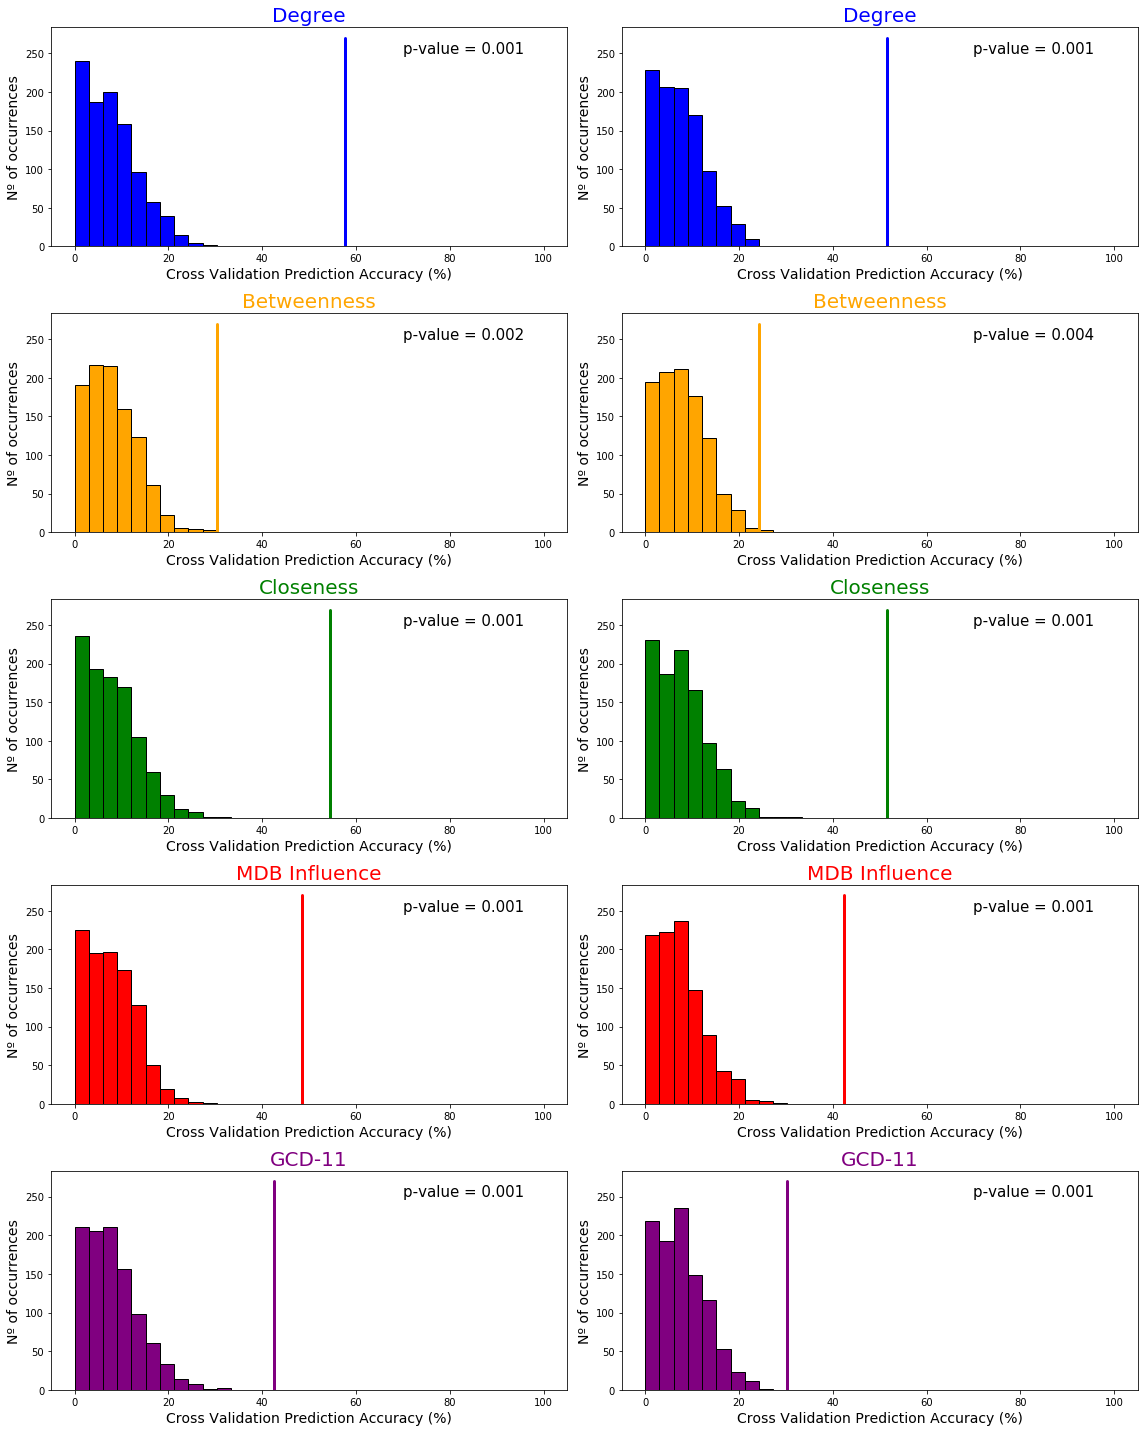

In [152]:
f, axes = plt.subplots(5, 2, figsize = (16,20))

Names = ['Degree - Negative GD', 'Betweenness', 'Closeness', 'MDB Inf.', 'GCD-11',
         'pos_Degree', 'pos_Betweenness', 'pos_Closeness', 'pos_MDB Inf.', 'pos_GCD-11']
colors = ['blue', 'orange', 'green', 'red', 'purple'] * 2
quadrant = [axes[0][0], axes[1][0], axes[2][0], axes[3][0], axes[4][0],
           axes[0][1], axes[1][1], axes[2][1], axes[3][1], axes[4][1]]
ylim = [0,270]
n_labels = len(degree_neg_TF.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(np.array(PMs_PLS[name])*100, n_labels, range=(0, 100.001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    q.plot(2 * [CV_PLS[name]*100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name], solid_capstyle='round')
    q.set_xlabel('Cross Validation Prediction Accuracy (%)', fontsize=14)
    q.set_ylabel('Nº of occurrences', fontsize=14)
    q.text(70,250, 'p-value = %.3f' % pvalue_PLS[name], fontsize = 15)
    if name.startswith('pos'):
        name = name.split('_')[-1]
        if name == 'MDB Inf.':
            name = 'MDB Influence'
    elif name.endswith('GD'):
        name = name.split(' ')[0]
    elif name == 'MDB Inf.':
        name = 'MDB Influence'
    q.set_title(name, size = 20, color = color)

plt.tight_layout()
#plt.savefig('Net-Perm-GD-PLSDA')